# Traveling salesman with GA 

### This notebook covers the creation of a Genetic Algorithm to tackle the TSP problem

Feel free to copy it and sugest improvements on github
https://github.com/jcanelhas/GAIntro

### Introduction to Genetic Algotithms (GA)

Genetic algorithms are an heuristic search and optimization technique that uses a mechanism inspired in the way living organisms pass their traits from one generation to the next. The genetic algorithm as we know it was first presented by John Holland in the book Adaptation in Natural and Artificial Systems.<br>
To create make an analogy with nature, so solutions are called individuals and a group of solutions is called a population.<br>
With a Darwinian approach, GAs try to mimic evolution and natural selection. Evolution is achieved by using operations that create change into the individuals and consequently to the population, the main mechanisms of evolution are: crossover and mutation. Natural selection is attained by classifying individuals using a fitness function; this function will evaluate how good the individual is and will affect the chance it has to pass traits to the next generation. The fitness function is highly dependent on the problem being solved.<br>
Genetic algorithms are appropriate for problems where an accurate solution (that may not be optimal) is needed and when there is no need for a real-time response.<br>
<br><br>__Advantages of GA.__<br><br>
Some benefits of Genetic algorithms are the ability to provide a very accurate result and usually provide an easy to understand solution to a problem, contrary to neural networks, where the inner workings are very hard to interpret.
<br><br>__Limitations of GA.__<br><br>
Some of the limitations of GA are: the cost of computing the fitness function, they are highly stochastic method, each run usually provides a different solution, so it is better to run several runs with the same parameters to obtain a solution, high dependence on the initial population that is randomly generated, high dependence on parameter settings, that is very hard to tweak, they do not guarantee to find the optimal solution.<br><br>
<hl>

### Module Import

The imports go here

In [4]:
#numpy 
import numpy as np

#some pretty plots
import matplotlib as plt

#notebook or inline 
%matplotlib inline
plt.rcParams["figure.figsize"]=(32,16)
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: middle;
    vertical-align: middle;
}
</style>
""")

#general math and random imports
from math import sqrt
from random import randint
from random import random

#For some cool widgets
from ipywidgets import FloatProgress
from IPython.display import display

### Read the cities file

Read a text file into an array

In [2]:
city_list=np.loadtxt('200.txt').astype(int)
print(str(len(city_list)) + " cities read")

200 cities read


Show a plot of the map with the cities

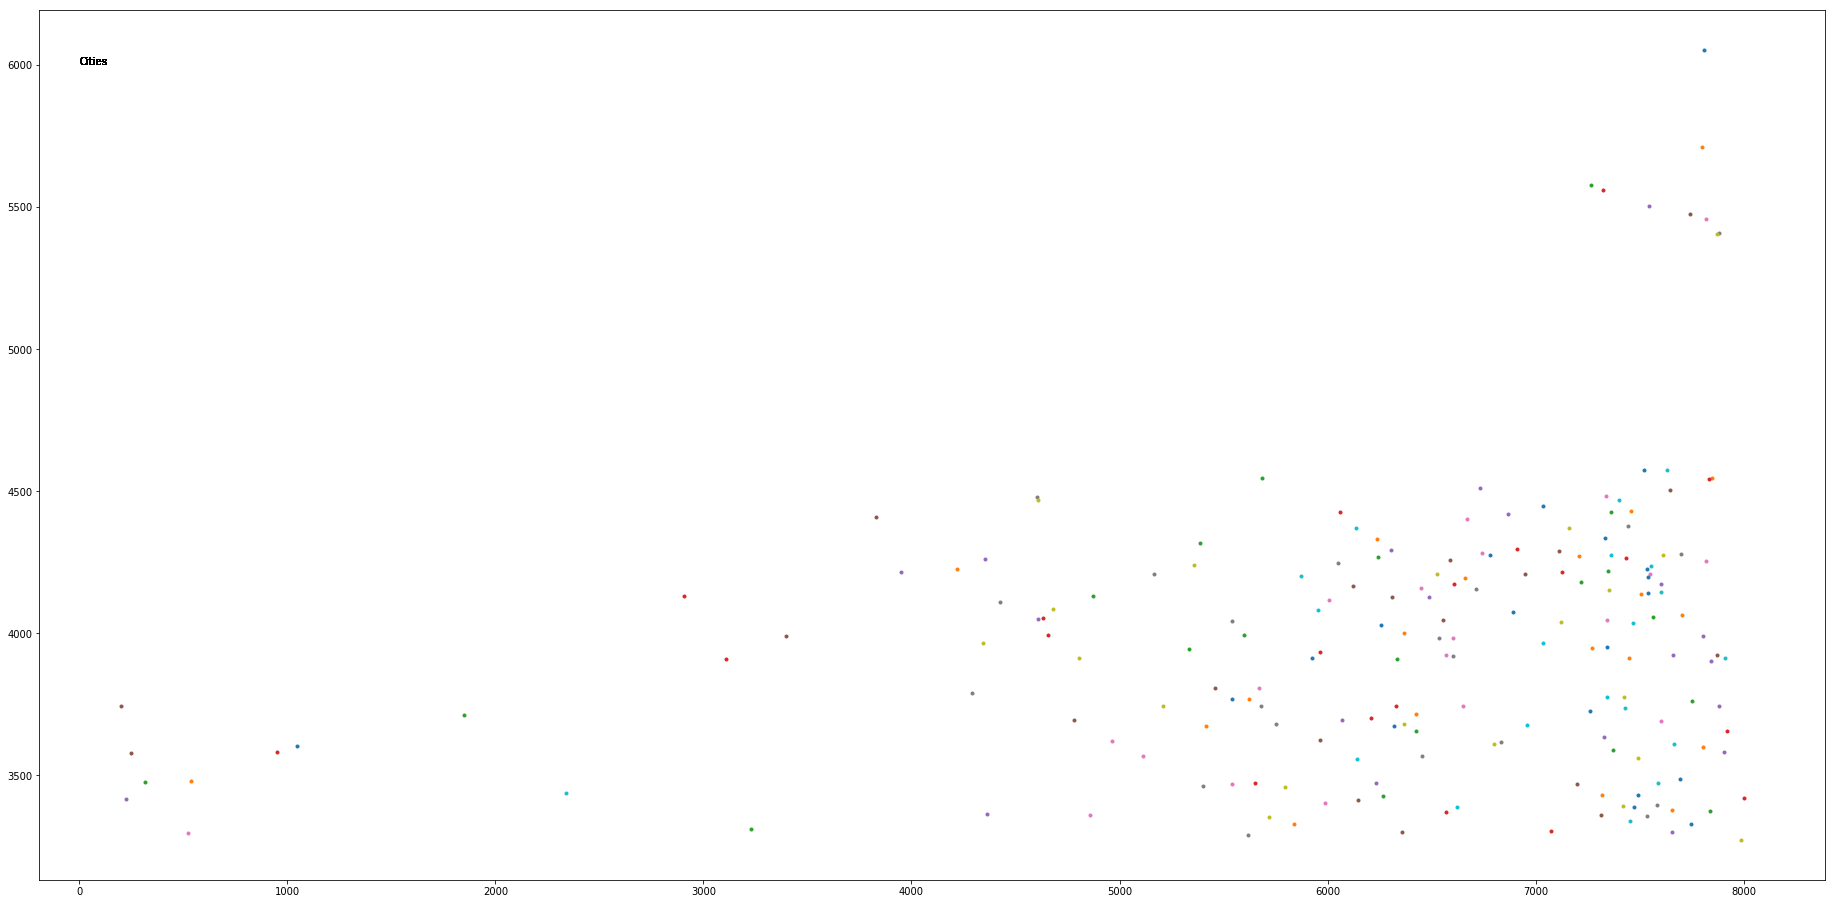

In [5]:
for city in city_list:
    plt.pyplot.plot(city[1],city[2],'.')
    plt.pyplot.text(1,6000,'Cities')
plt.pyplot.show()

### Set the initial parameters

In [6]:
#Number of individuals on a population
nindividuals=300
#Number of cities being processed
ncities=len(city_list)
#Tournmentsize
tournamentsize=10

#crossover and mutation probability
cx_probability=0.9
mx_probability=0.5

#maximum number of generations to run
max_iterations=1000

## Define general functions

### Euclidean Distance

The euclidian distance is calculated using $$d=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$$

In [7]:
def euclidian_distance(x1,y1,x2,y2):
    dist = sqrt((x1-x2)**2+(y1-y2)**2)
    return dist

### Calculate fitness

To calculate the fitness we will add the euclidian distance from the first city to the last through the path presented by the individual<br><br>
$$fitness=\sum_{i=0}^{ncities-1} \sqrt{(x_1-x_2)^2+(y_1-y_2)^2} $$
<br> where :
$$(x_1,y_1)$$ and $$(x_2,y_2)$$ Are the coordinates of the cities

In [8]:
def calculate_fitness(individual):
    fitness=0
    #First element
    fitness=euclidian_distance(city_list[individual[0]][1],city_list[individual[0]][2],
                               city_list[individual[1]][1],city_list[individual[0]][2])
    for i in range(1,len(individual)-1):
        fitness=fitness+euclidian_distance(city_list[individual[i]][1],city_list[individual[i]][2],
                                           city_list[individual[i+1]][1],city_list[individual[i+1]][2])
    return fitness

### Mutation

In [9]:
def mutate(individual):
    #reverse mutation
    init_pos=np.random.randint(0,len(individual))
    end_pos=np.random.randint(init_pos,len(individual)+1)
    mutated_individual= np.concatenate((individual[:init_pos],
                                        individual[init_pos:end_pos][::-1],
                                        individual[end_pos:]),axis=0)
    return mutated_individual

### Crossover

In [10]:
def crossover(individual1,individual2):
    splitpoint=randint(0,len(individual1)-1)
    result1=np.copy(individual1)
    result2=np.copy(individual2)
    currpos=splitpoint
    firstval=individual1[splitpoint]
    newpos=0
    
    cycleover=False
    
    while True:
         
            
        result1[currpos]=individual2[currpos]
        result2[currpos]=individual1[currpos]

        newpos=np.where(individual1==individual2[currpos])

        currval=individual2[currpos]

        if firstval==currval:#individual2[currpos]:

            cycleover=True        

        currpos=newpos
        if cycleover:
            break

   
    return(result1,result2)

### Tournament Selection

Tournament selections randomly picks a number of individuals and compares them, the one with the best fitness is selected. This method is fast compared to other methods because there is no need to evaluate EVERY individual in the population.

In [11]:
def tournament_selection(pop, tournament_size):
    
    champion=population[np.random.randint(len(pop))]
    champion_fitness=calculate_fitness(champion)
    
    for i in range(0,tournament_size):
        tmpind=population[np.random.randint(len(pop))]
        tmpind_fitness=calculate_fitness(tmpind)
        if tmpind_fitness<champion_fitness:
            champion=tmpind[:]
            champion_fitness=tmpind_fitness
    return champion

### Initialization

In [12]:
population=np.zeros((nindividuals,ncities),dtype=int)
for individual in range(0,nindividuals):
    population[individual]=np.arange(ncities)
    np.random.shuffle(population[individual])

In [13]:
#lets see the population
population

array([[106,  92,  68, ...,  63,  95, 127],
       [ 82, 165, 108, ...,  54,  91, 128],
       [174,  41,  42, ..., 148, 178, 153],
       ..., 
       [170,  83,  97, ..., 182,   8, 193],
       [ 87, 125, 145, ..., 139, 157, 181],
       [ 61,  77, 186, ..., 166, 193,  89]])

In [14]:
def draw_scatter_plot(texto=''):
    ##prepare scatter
    xx=list()
    xx[:]=()
    yy=list()
    yy[:]=()

    best_individual=0
    best_individual_fitness= calculate_fitness(population[0])

    tot=0
    
    for i in range(0,nindividuals):
        cfit=calculate_fitness(population[i])
        tot=tot+cfit
        if cfit<best_individual_fitness:
            best_individual=i
            best_individual_fitness=calculate_fitness(population[i])


    for i in population[best_individual]:
        xx.append(city_list[i][1])
        yy.append(city_list[i][2])

    print("Best individual is number " + str(best_individual) + " with a fitness of " + str(best_individual_fitness))
    print("Average fitness is " + str(tot/len(population)))

    plt.pyplot.scatter(xx,yy,c='r',marker='o')
    plt.pyplot.plot(xx,yy)
    
    #This is hardcoded to the cities example if you are using another file make sure the positions are still valid
    plt.pyplot.text(1,6000,texto + '  Best fitness :' + str(best_individual_fitness))
    plt.pyplot.show()

Best individual is number 171 with a fitness of 329078.71749231056
Average fitness is 375601.8640669526


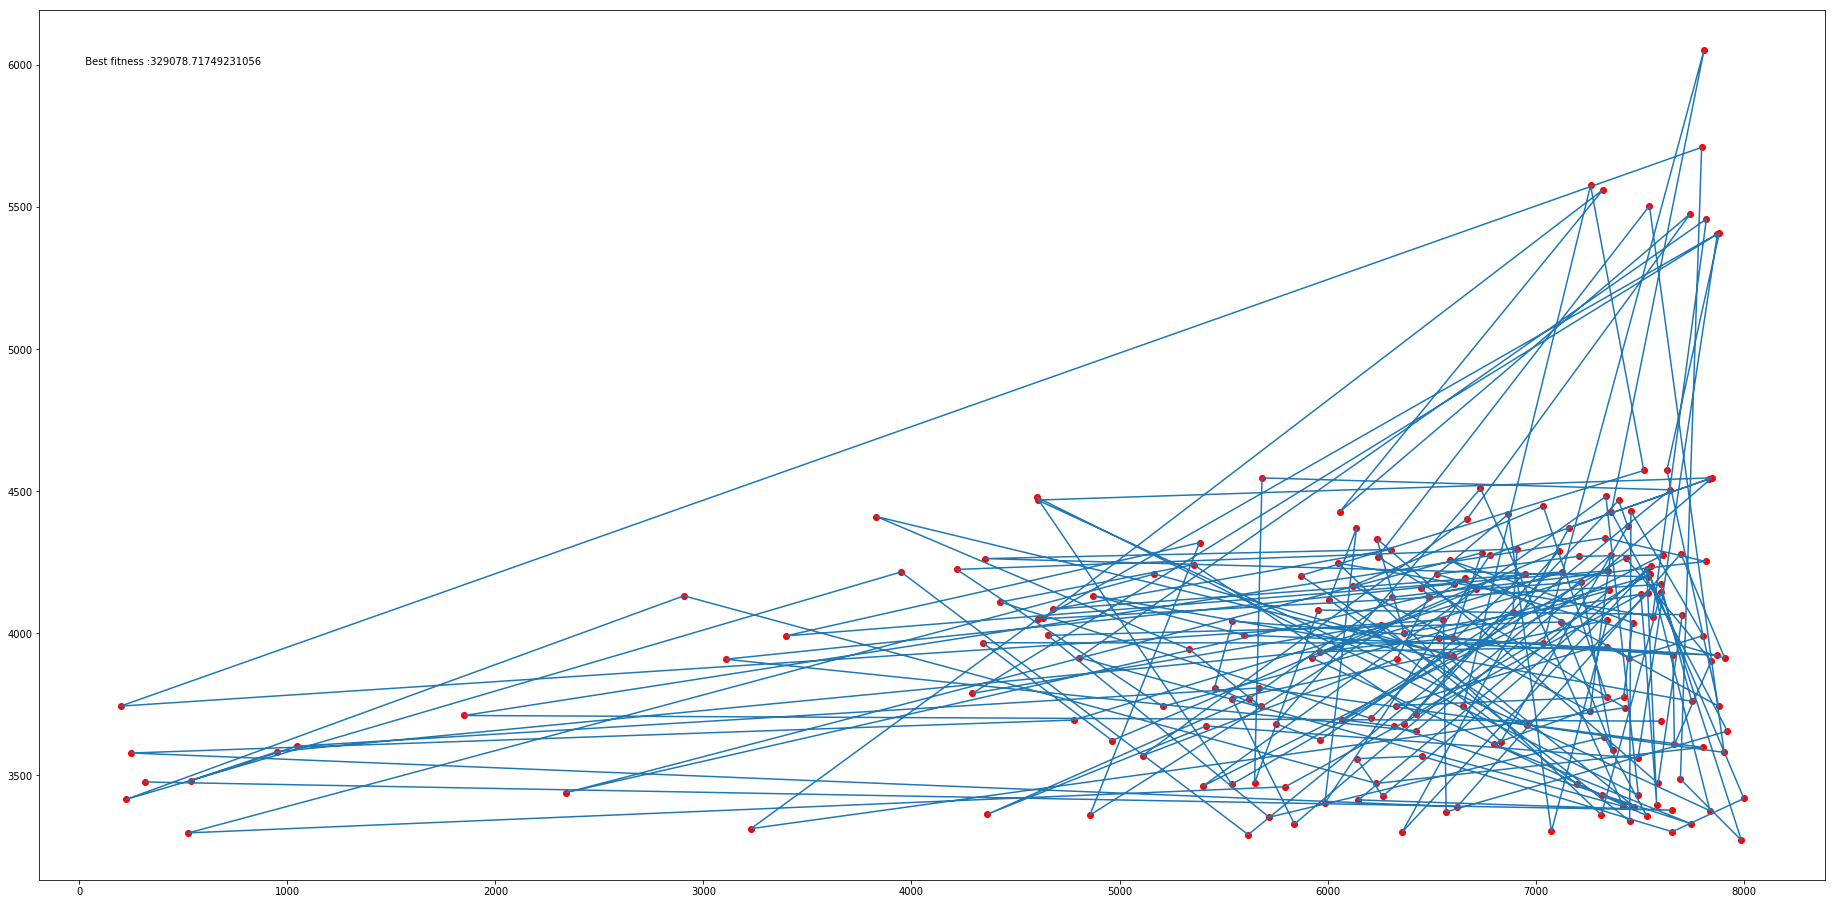

In [15]:
#this is the best solution on the randomized initial population
draw_scatter_plot()

# The Genetic Algorithm

The genetic algorithm works as following<br>
1. Create a population P of n random individuals.<br>
2. Repeat until the termination criteria are satisfied.<br>
2.1. Calculate fitness of all individuals4.<br>
2.2. Create an empty population P'.<br>
2.3. Repeat until P' is filled.<br>
2.3.1. Choose a genetic operator, (crossover with probability Pc, otherwise, reproduction with probability 1-Pc<br>
2.3.2. Select two individuals with a selection algorithm<br>
2.3.3. Apply operator selected in 2.3.1 to the individuals selected in 2.3.2.<br>
2.3.4. Apply mutation to individuals obtained in 2.3.3 with a probability of Pm.<br>
2.3.5. Insert resulting individuals into P'<br>
2.3.6. Iterate until P' contains n individuals.<br>
2.4. Replace P with P'.<br>
3. Return the best individual.<br>

FloatProgress(value=0.0, max=1000.0)

------0
Best individual is number 171 with a fitness of 329078.71749231056
Average fitness is 375601.8640669526


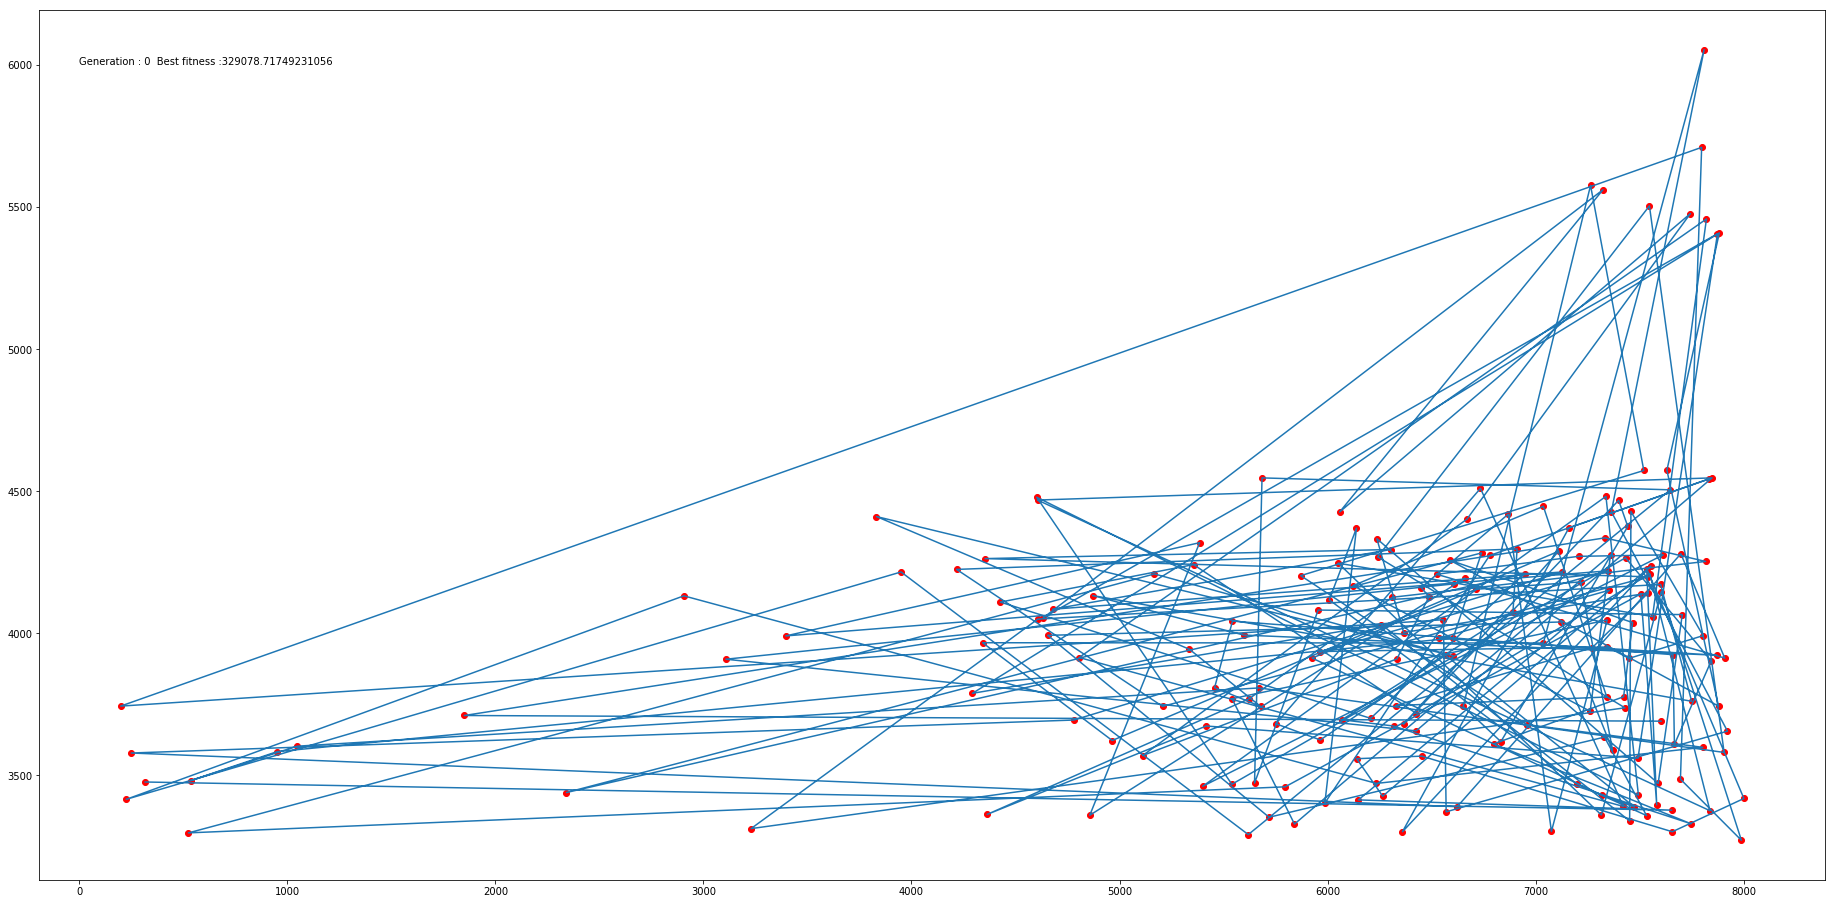

------50
Best individual is number 193 with a fitness of 206833.8423812323
Average fitness is 228686.49918963978


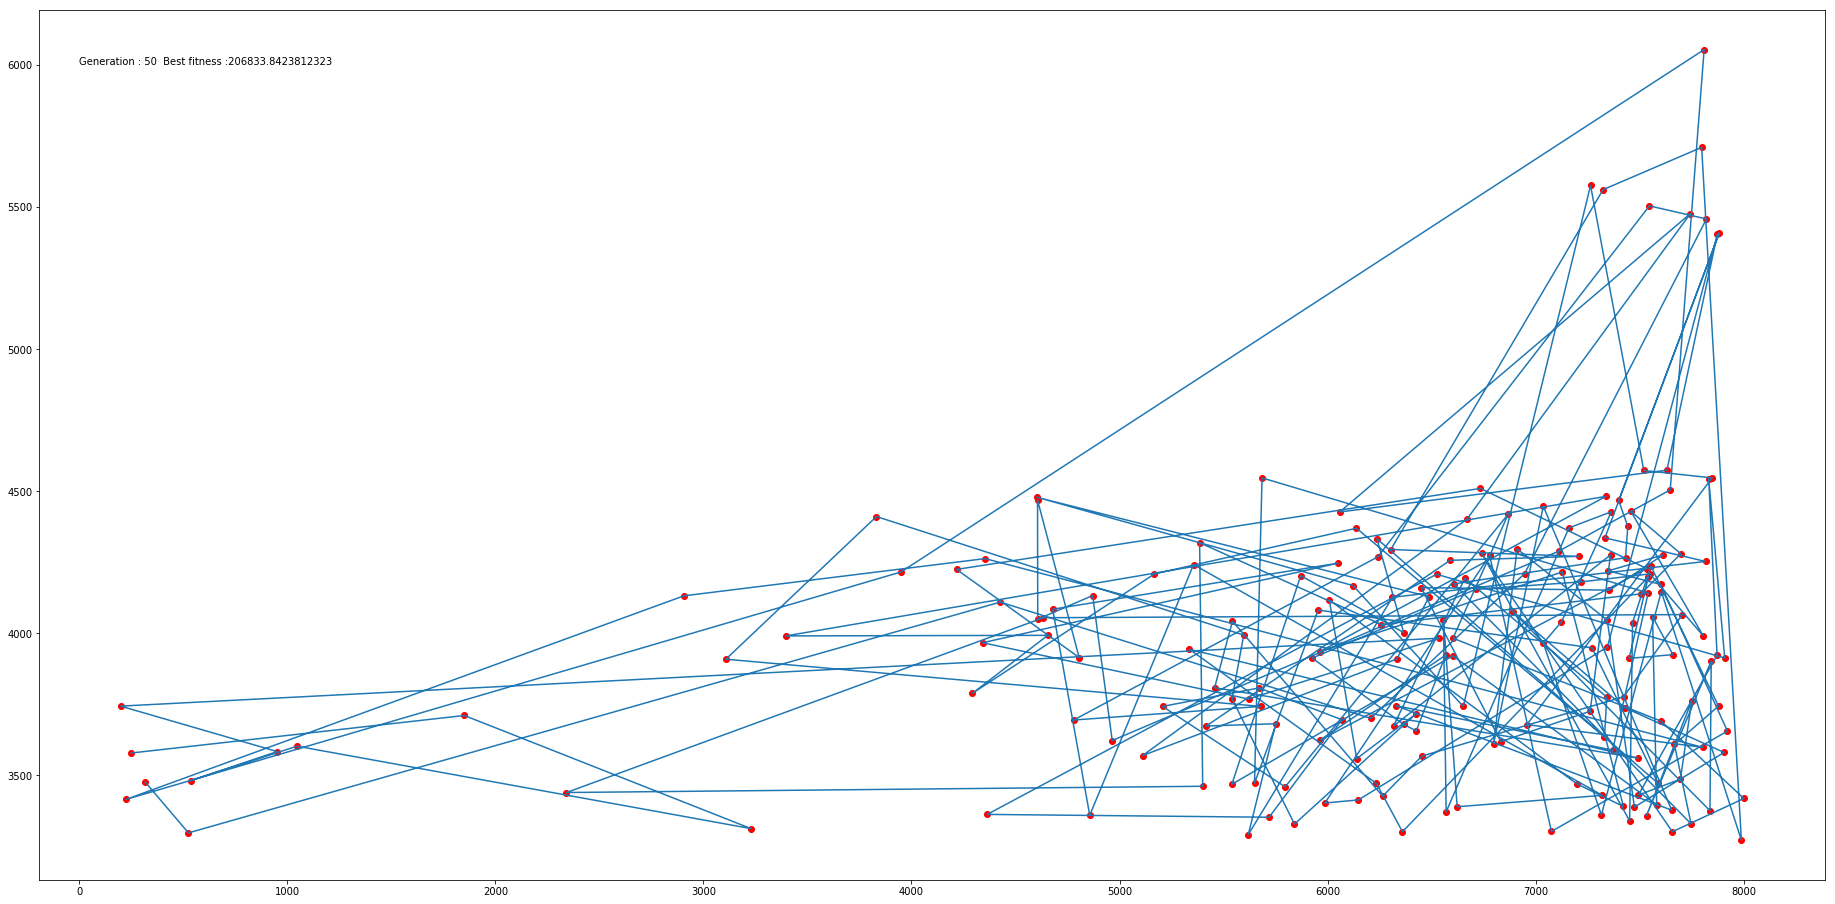

------100
Best individual is number 216 with a fitness of 156008.6453824477
Average fitness is 163994.4783481979


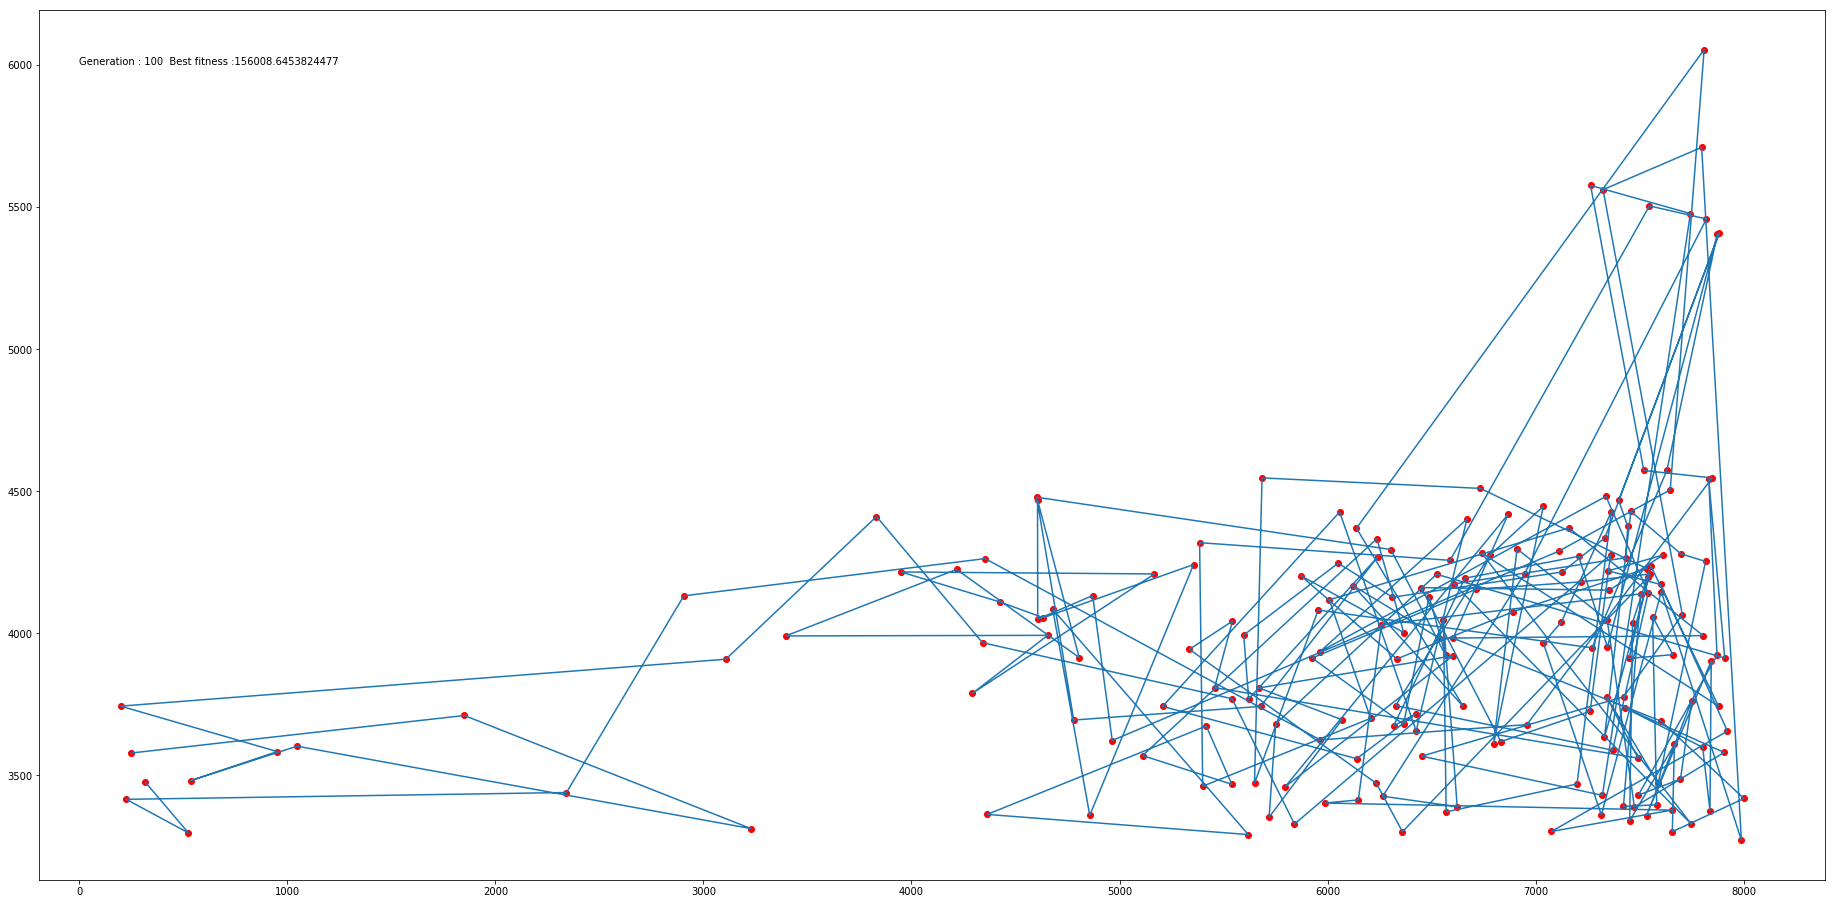

------150
Best individual is number 1 with a fitness of 128414.90828865052
Average fitness is 142978.22446461726


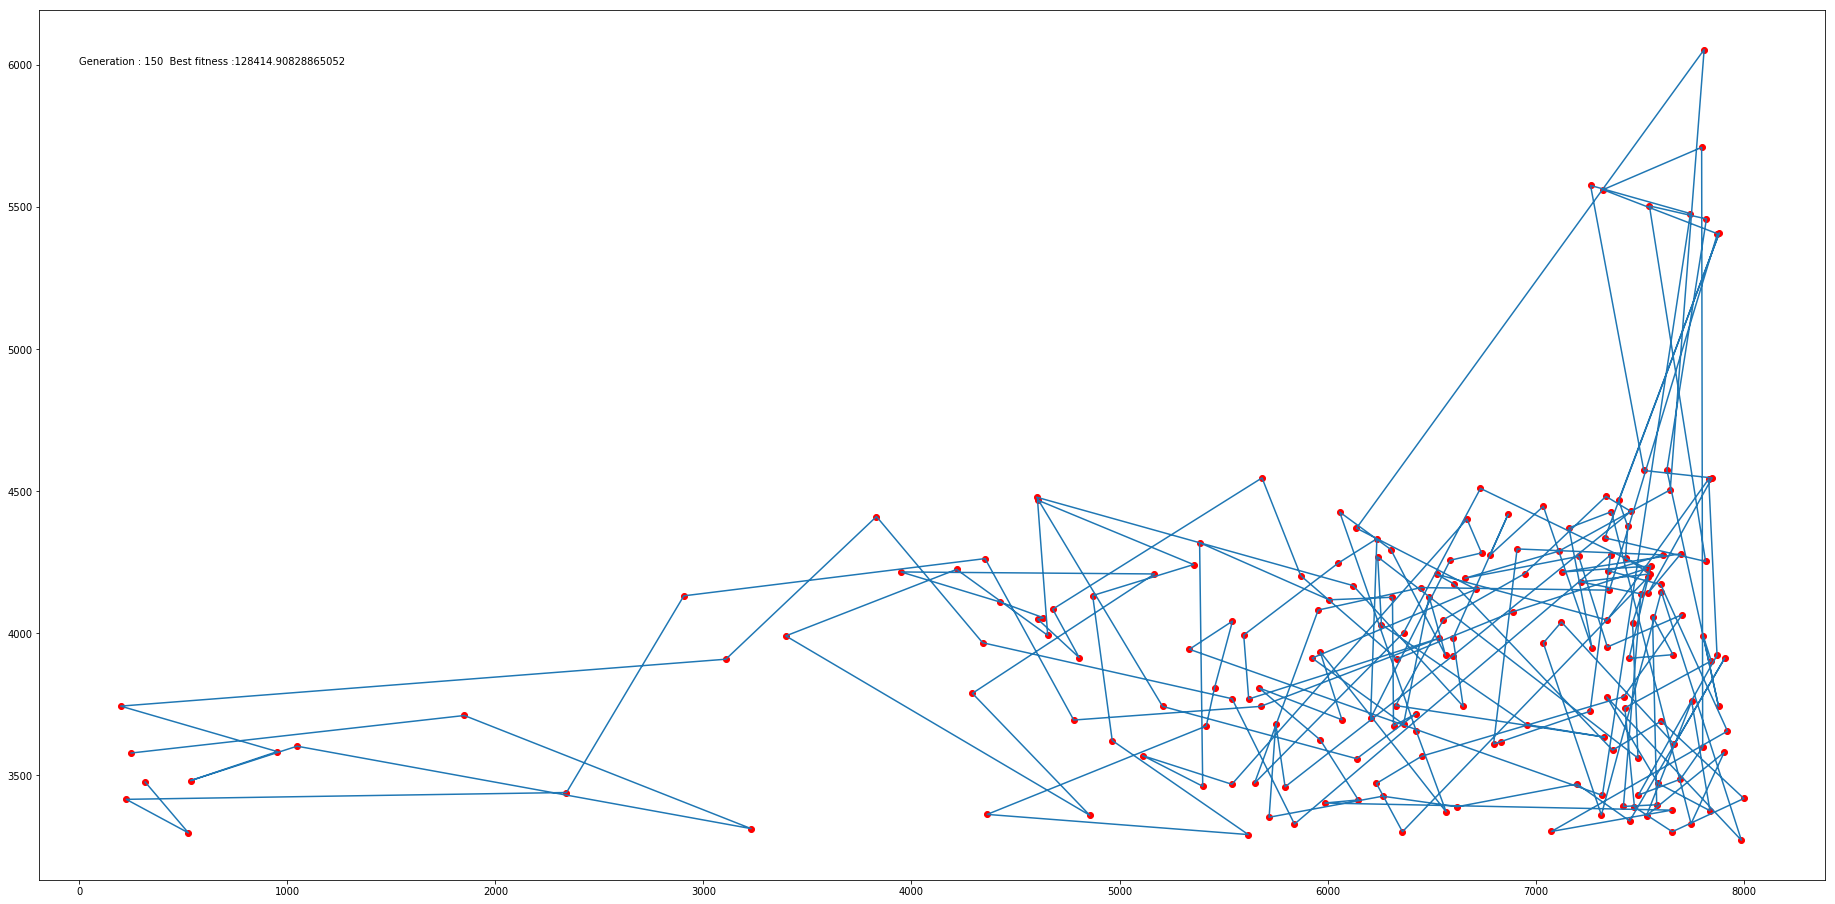

------200
Best individual is number 270 with a fitness of 106921.88778275672
Average fitness is 115772.4662380358


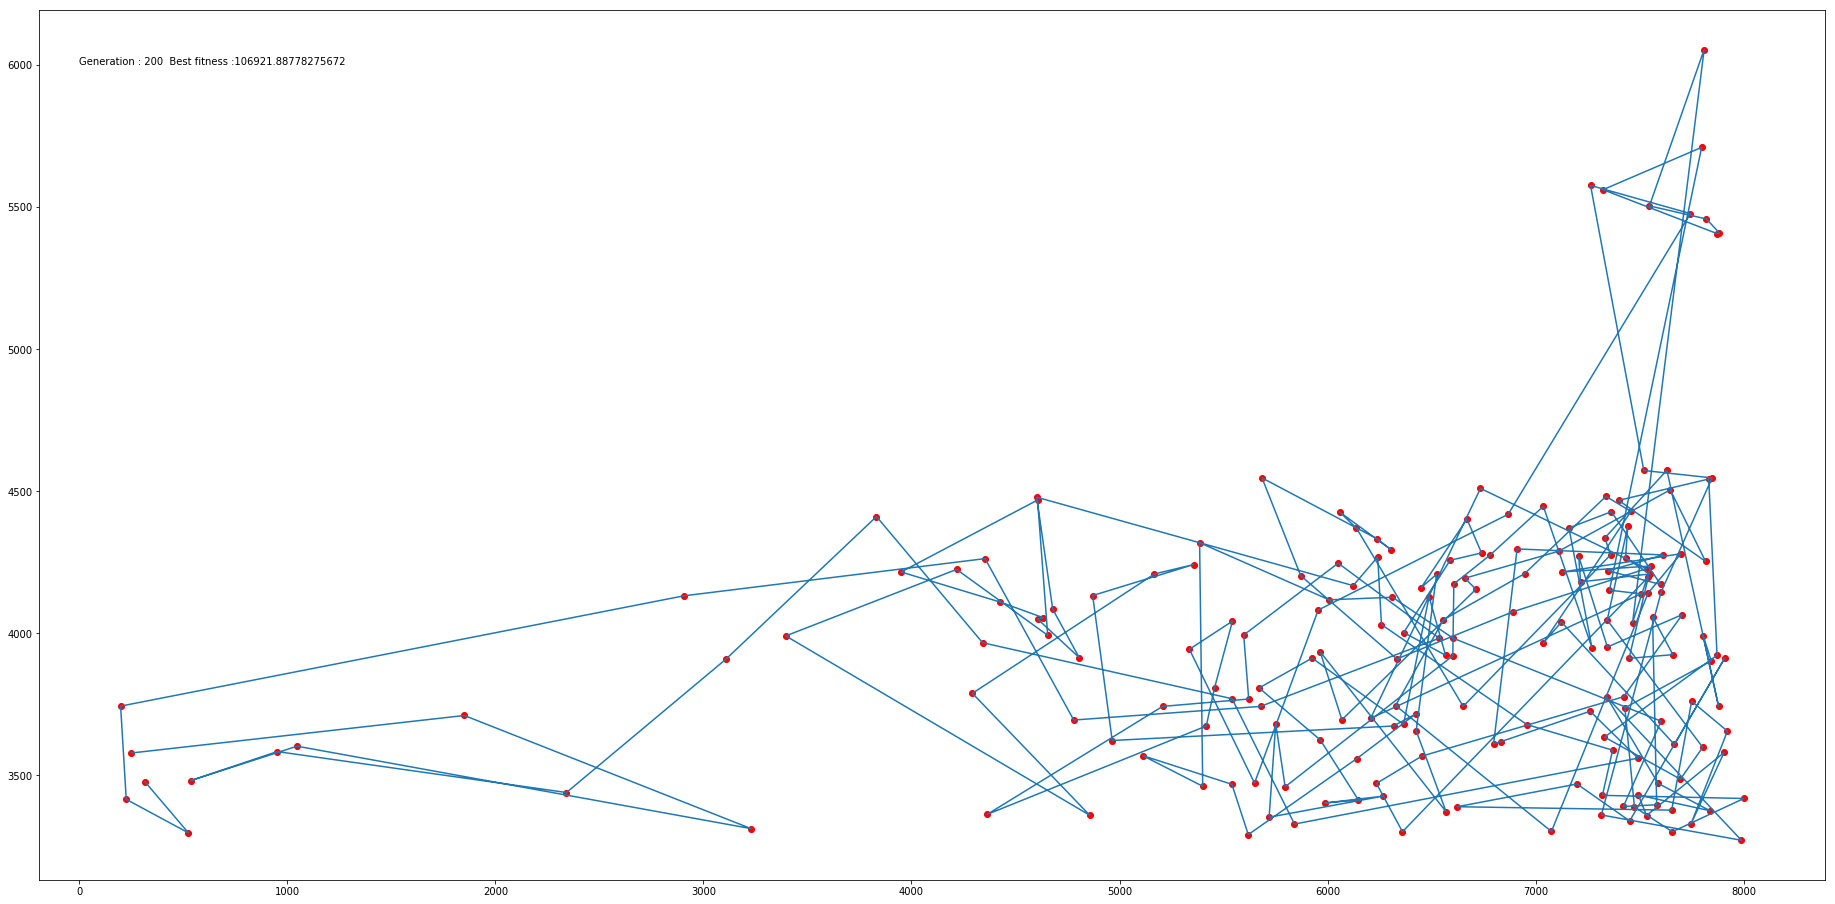

------250
Best individual is number 229 with a fitness of 93008.0571642619
Average fitness is 96001.30760097


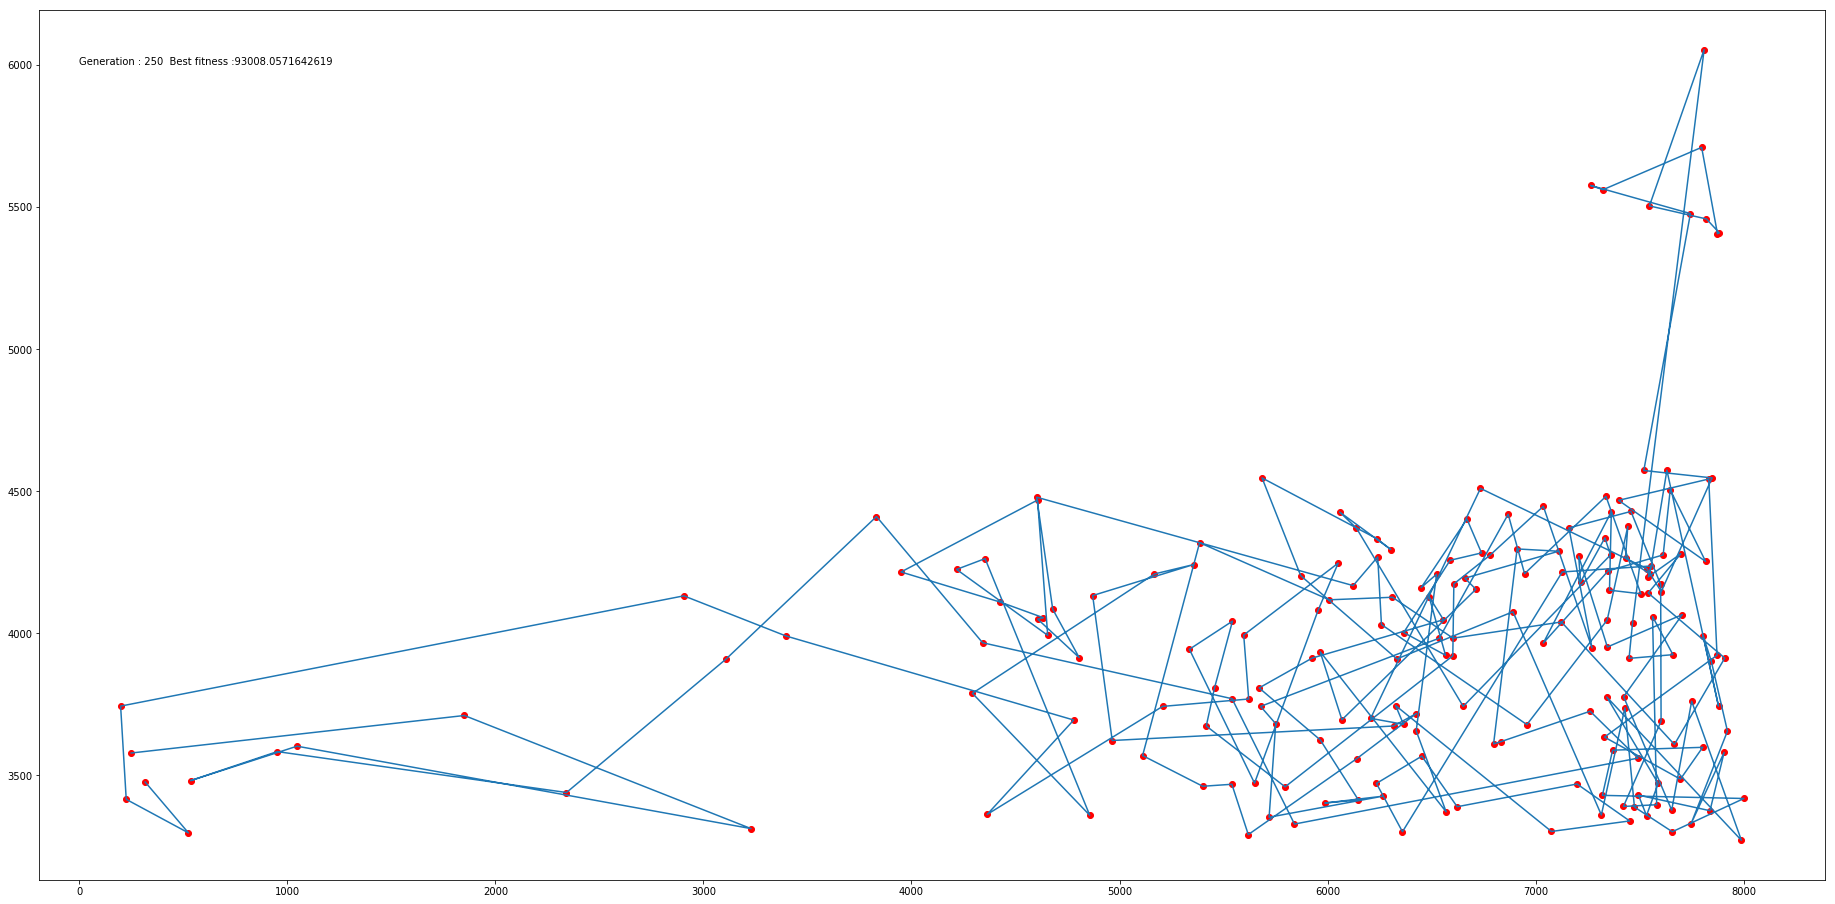

------300
Best individual is number 96 with a fitness of 83405.9768965722
Average fitness is 88652.25139563534


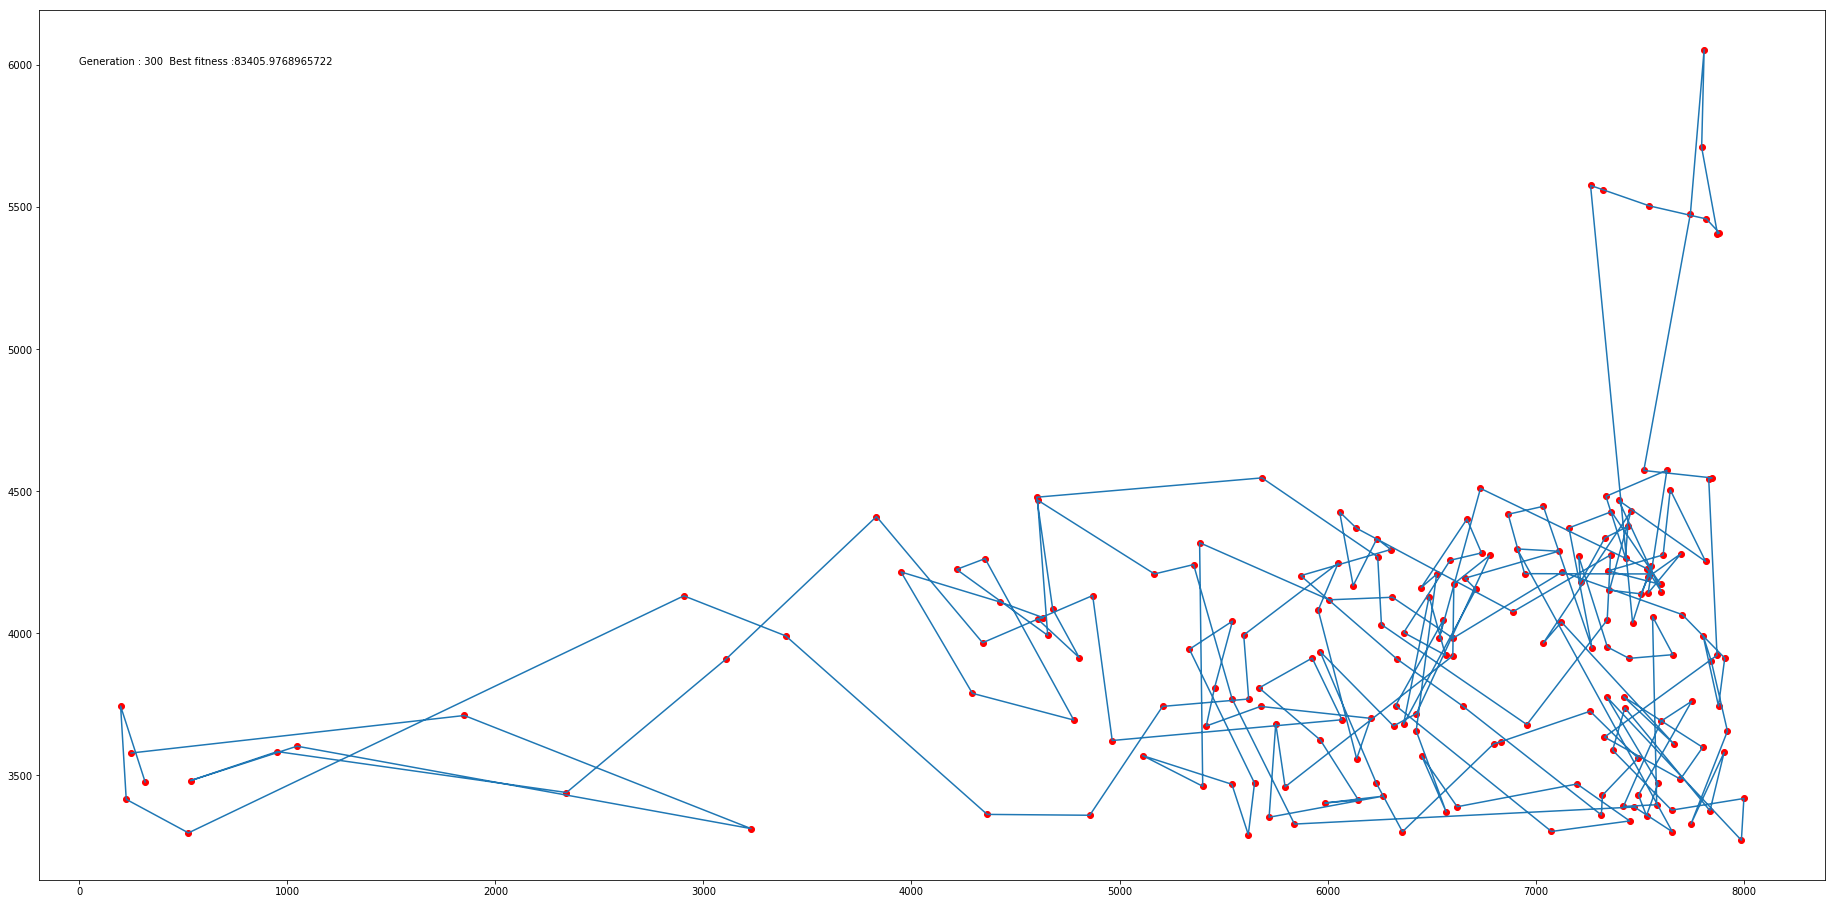

------350
Best individual is number 256 with a fitness of 72297.88013213406
Average fitness is 75508.08767626027


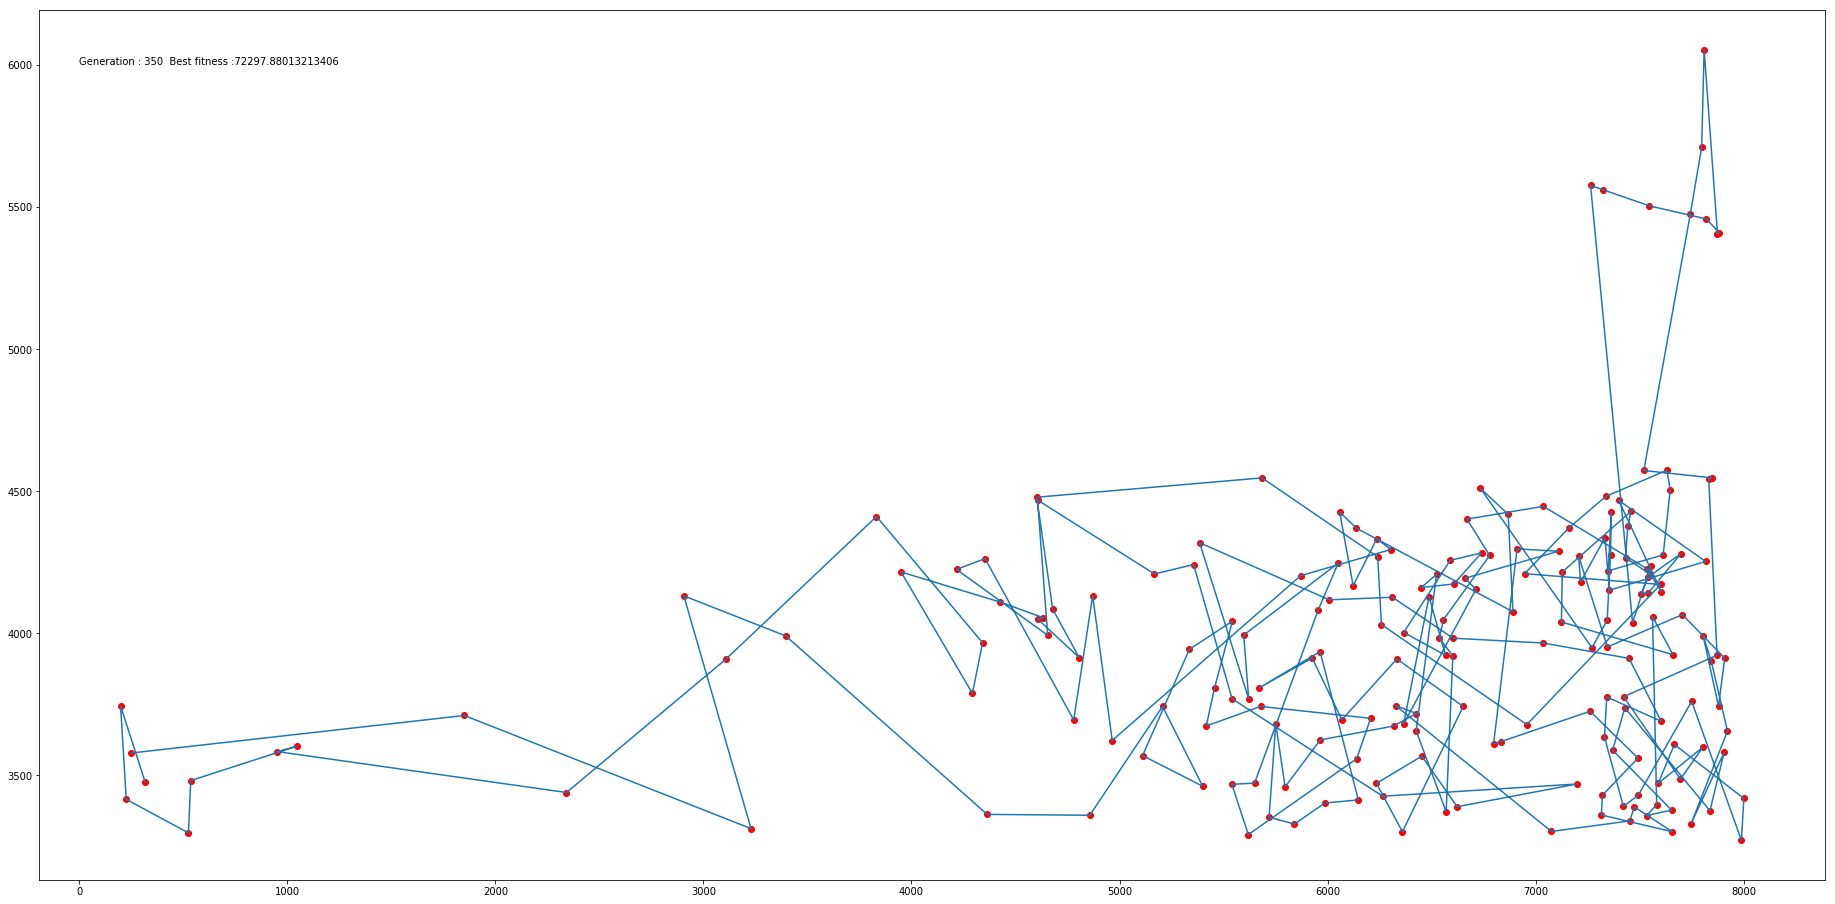

------400
Best individual is number 51 with a fitness of 65381.49212751903
Average fitness is 67441.86289442703


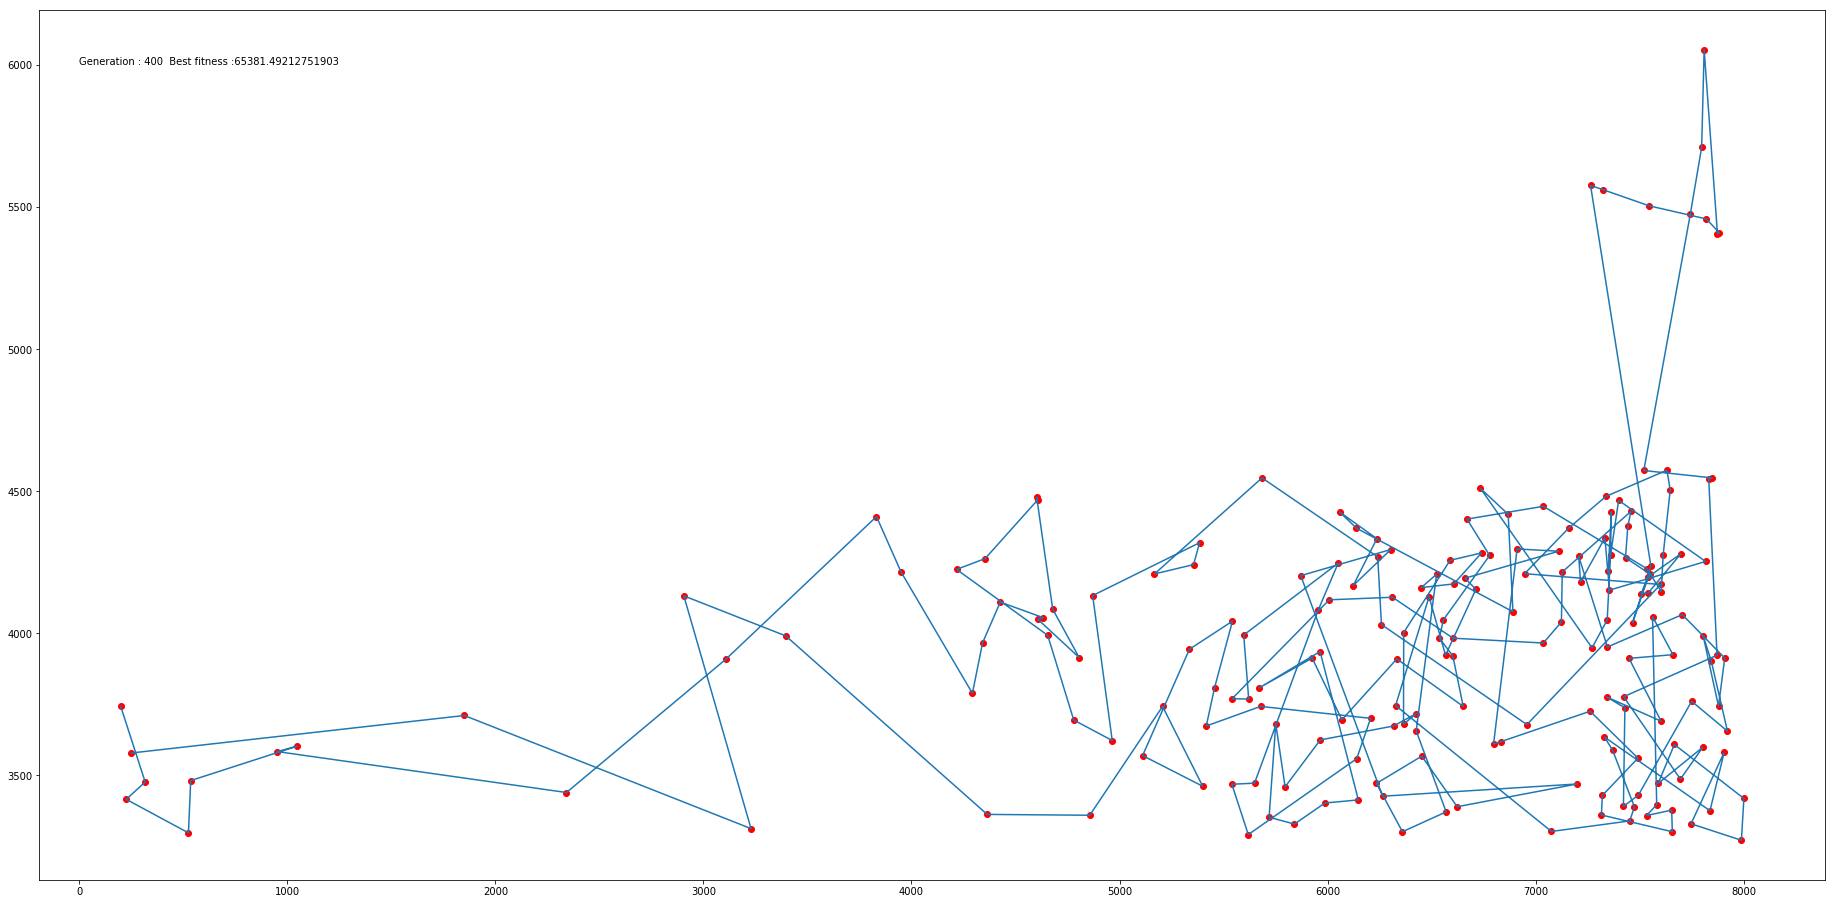

------450
Best individual is number 29 with a fitness of 58897.86774108538
Average fitness is 61029.22582767125


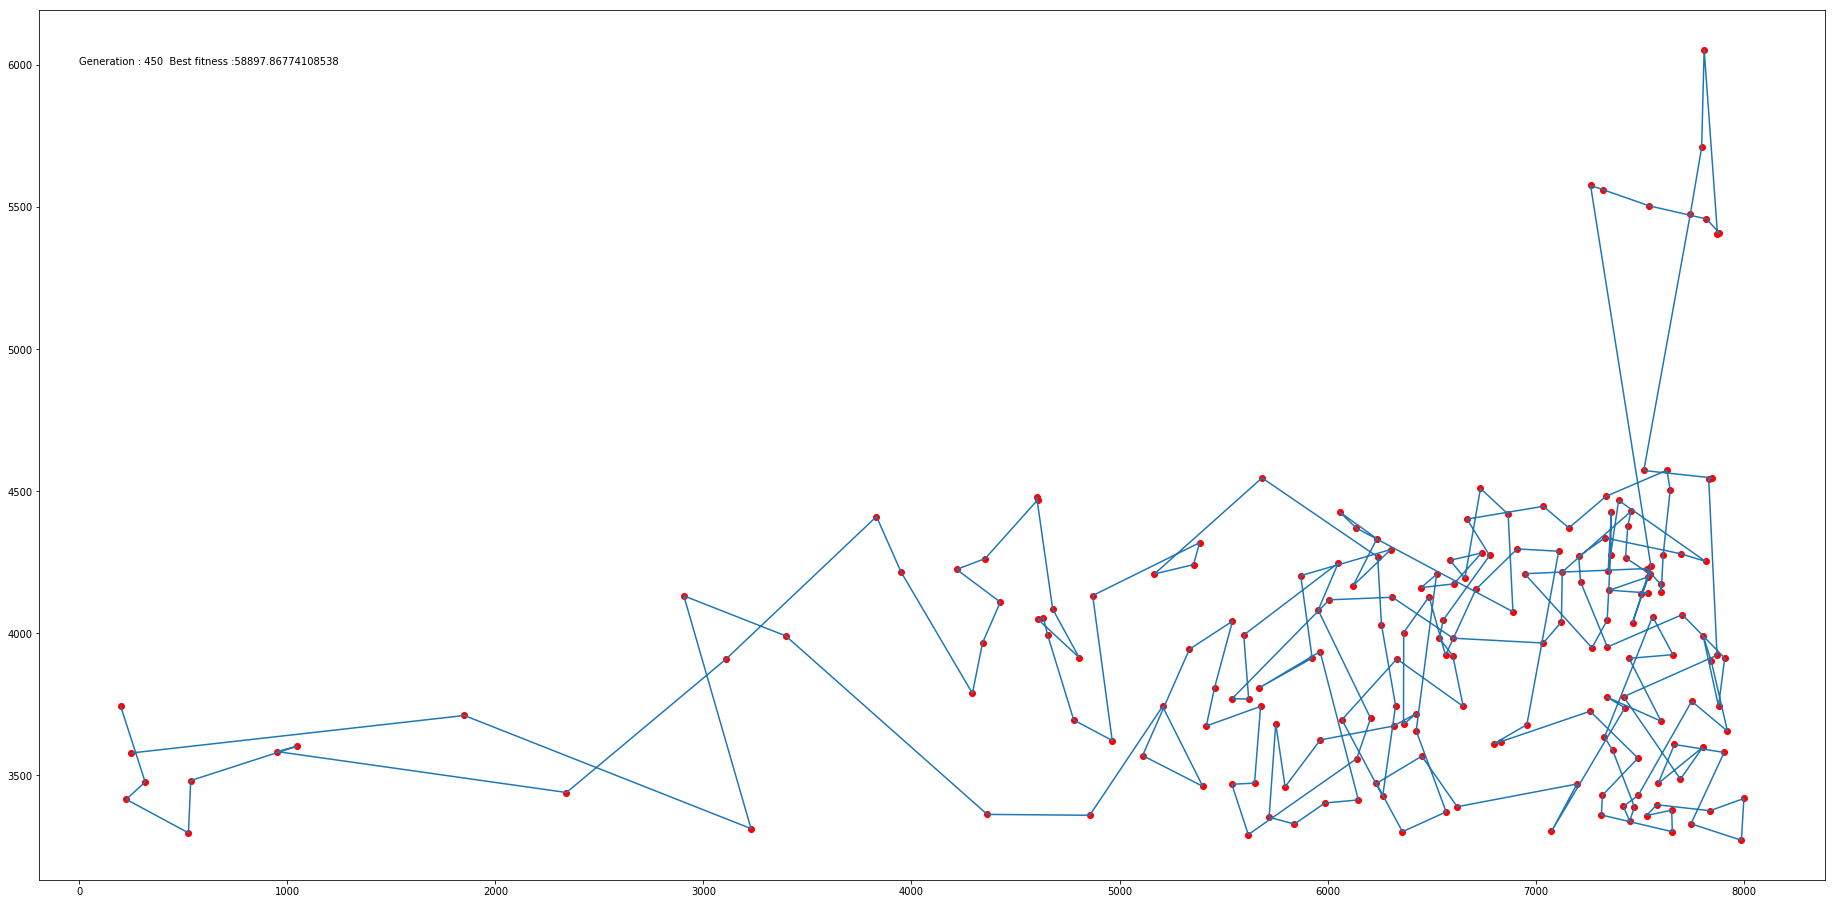

------500
Best individual is number 287 with a fitness of 54033.40956452961
Average fitness is 55603.97568132286


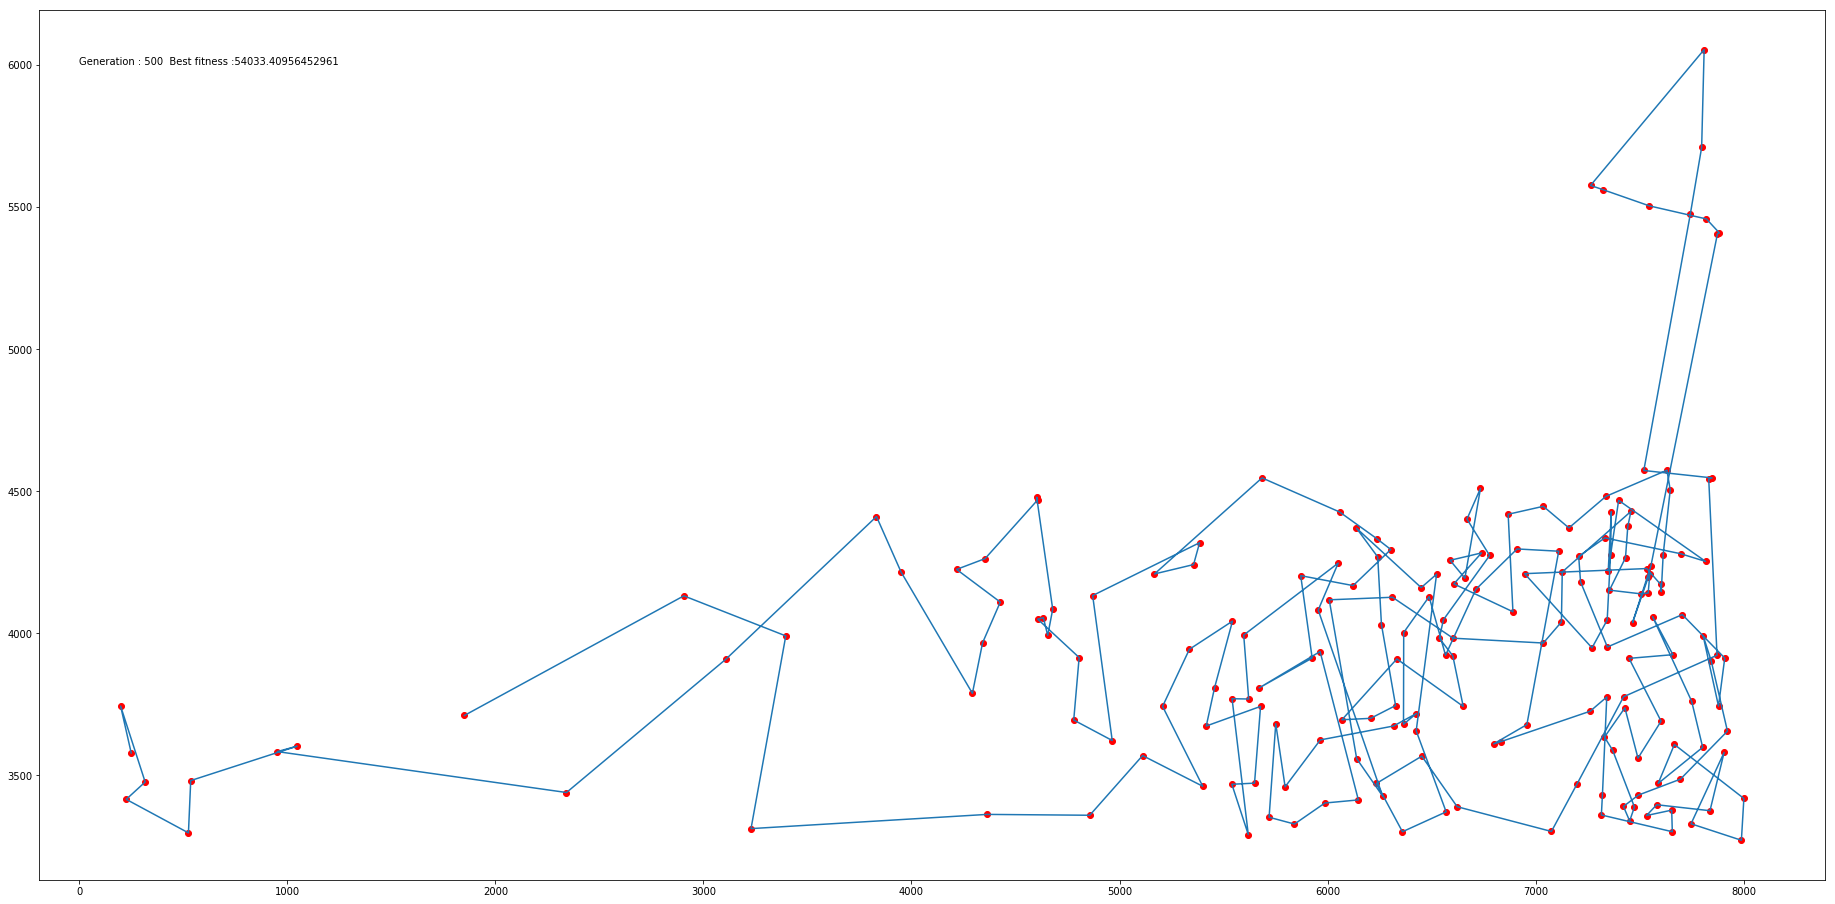

------550
Best individual is number 110 with a fitness of 50375.11284948471
Average fitness is 52852.98621466452


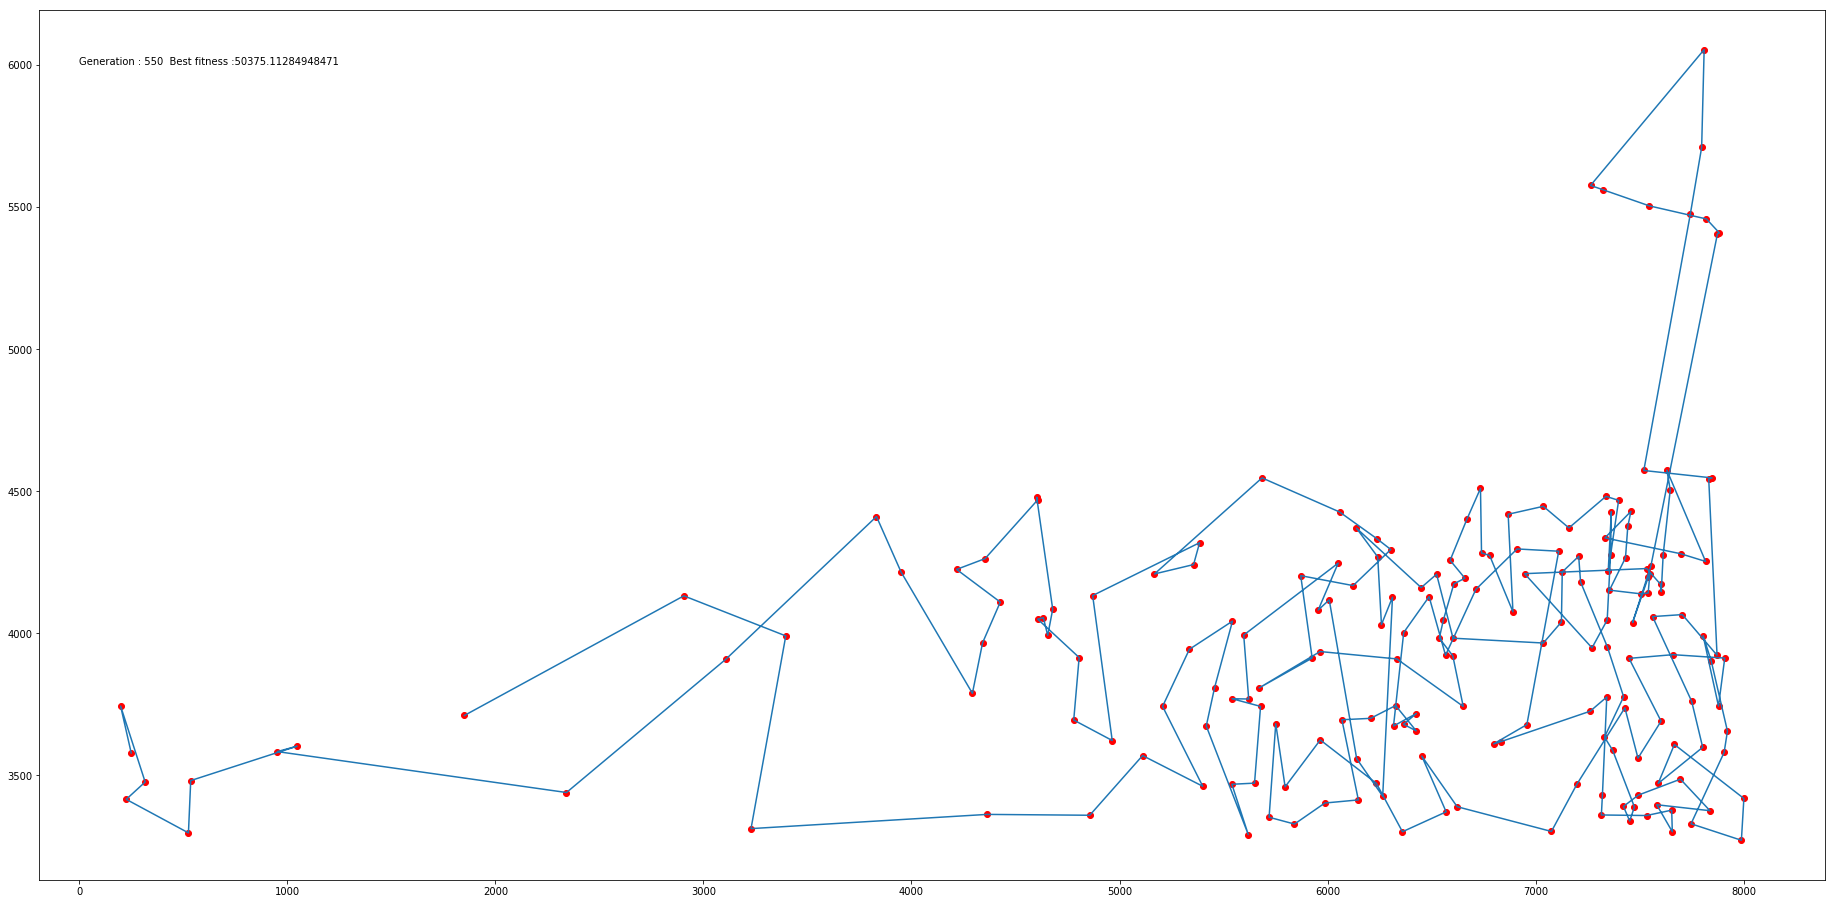

------600
Best individual is number 186 with a fitness of 47540.6366570562
Average fitness is 50161.77561213277


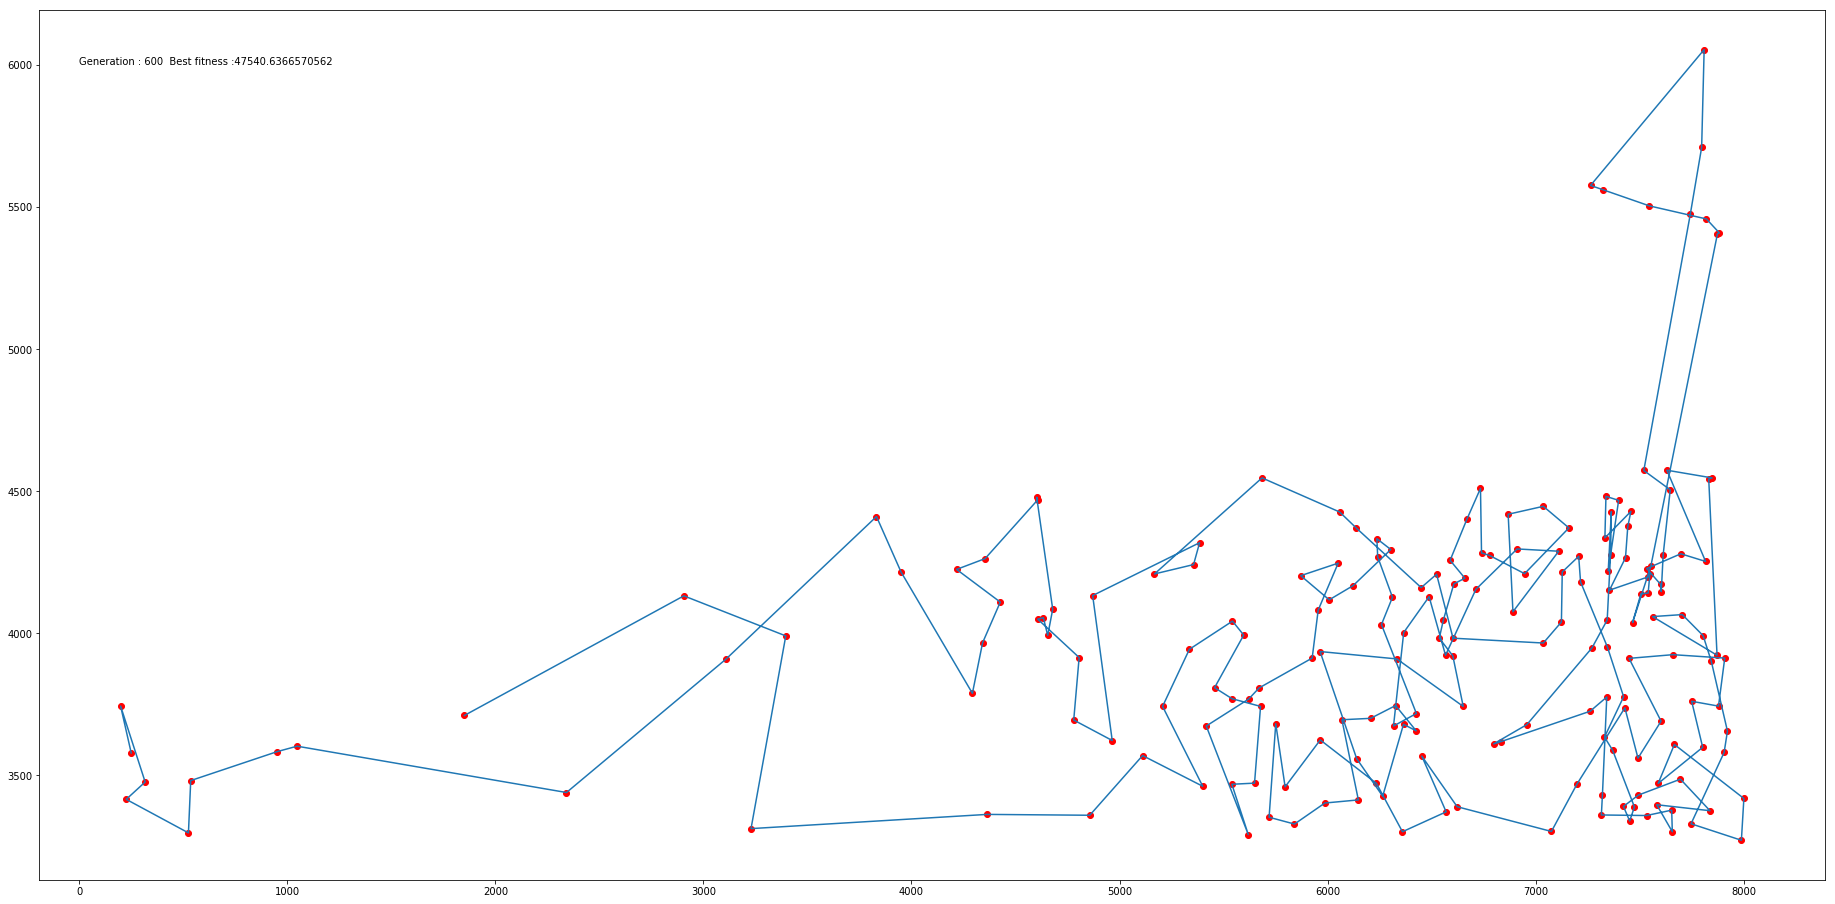

------650
Best individual is number 74 with a fitness of 44530.83962649512
Average fitness is 46370.18092944759


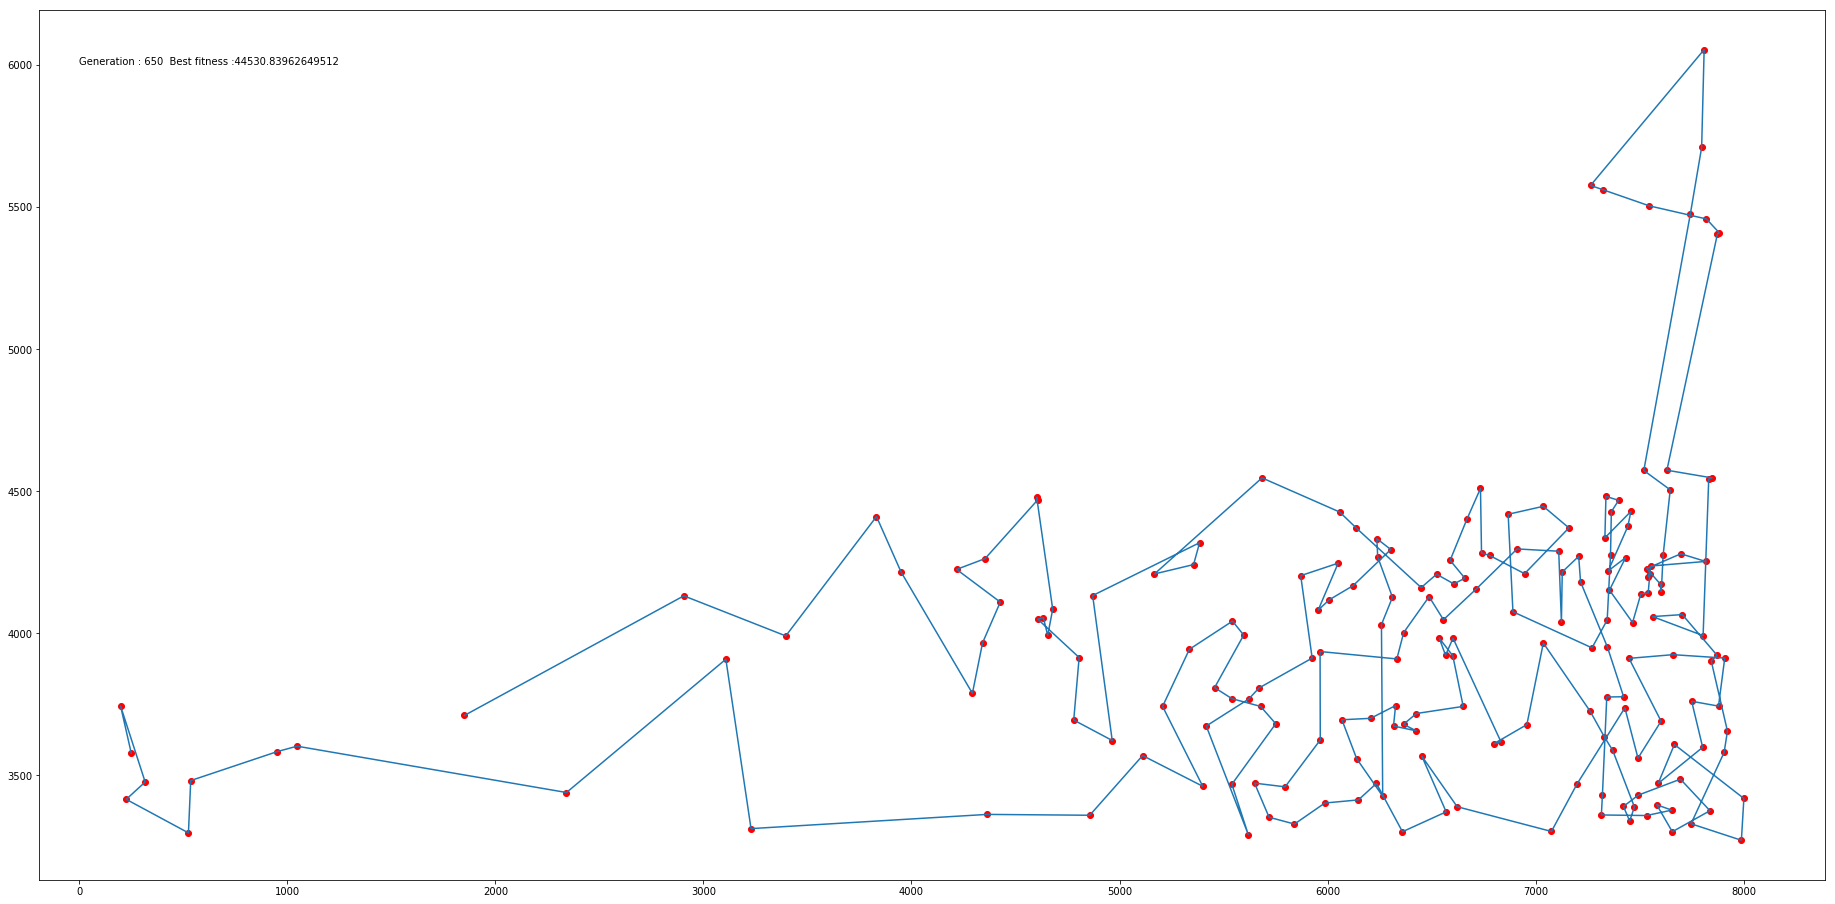

------700
Best individual is number 6 with a fitness of 42995.565990465926
Average fitness is 44436.96780836183


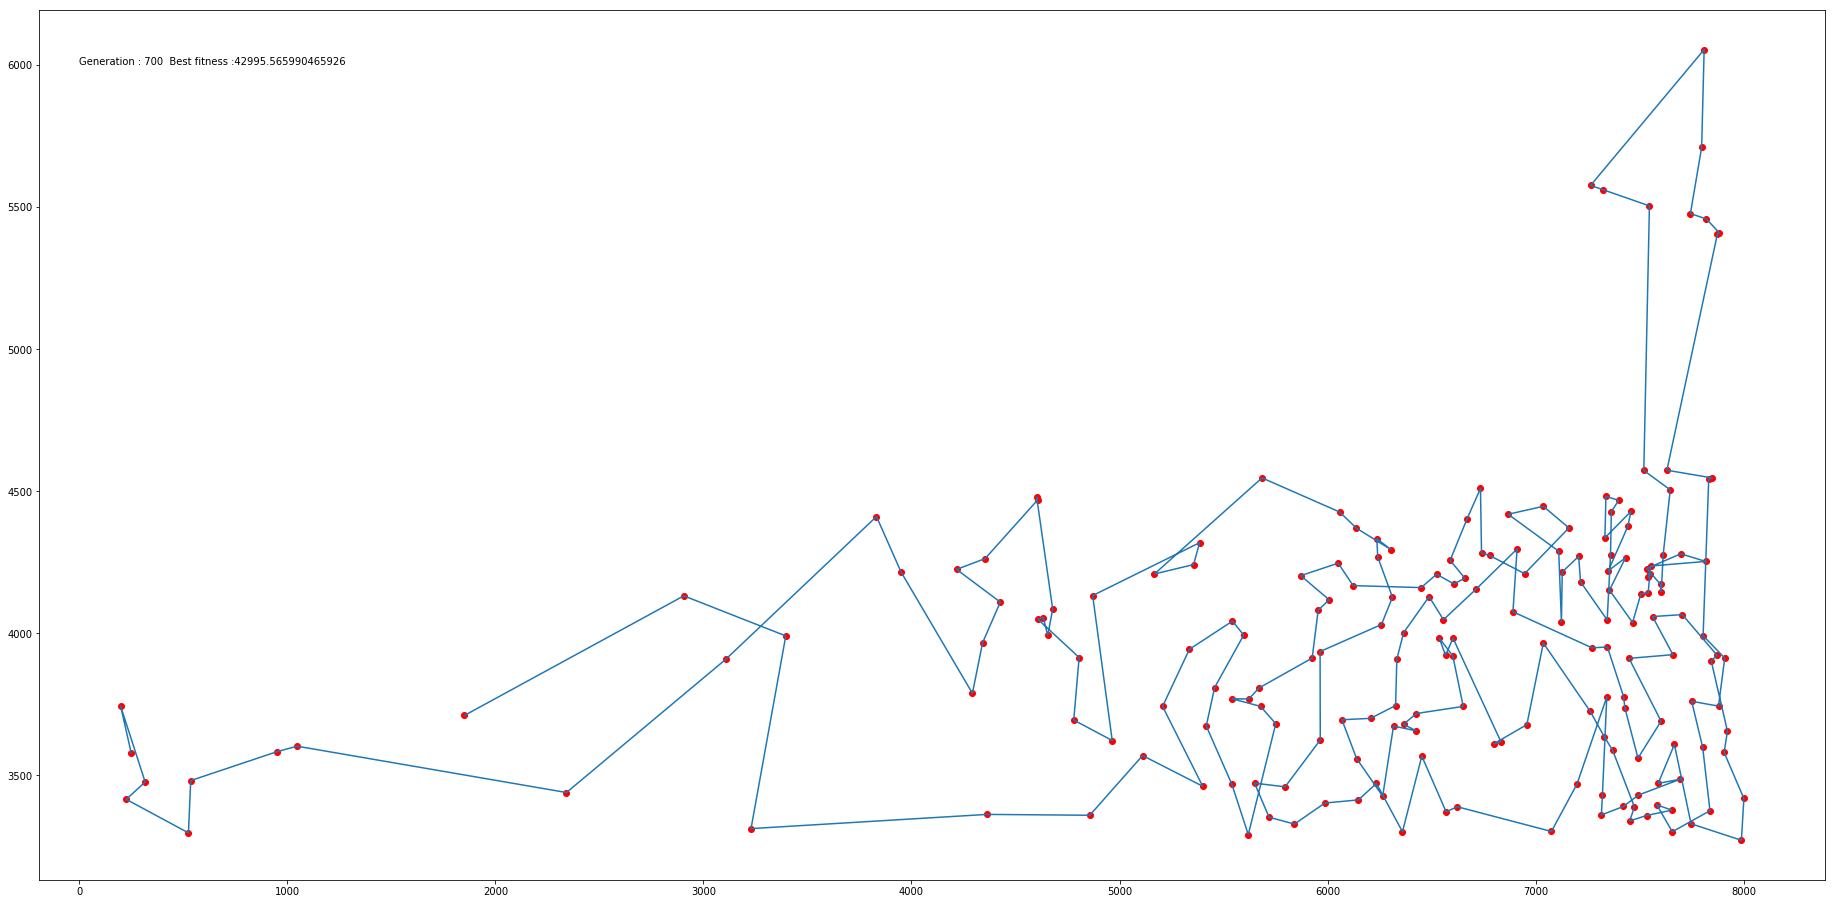

------750
Best individual is number 168 with a fitness of 41956.060755500635
Average fitness is 43196.16130186413


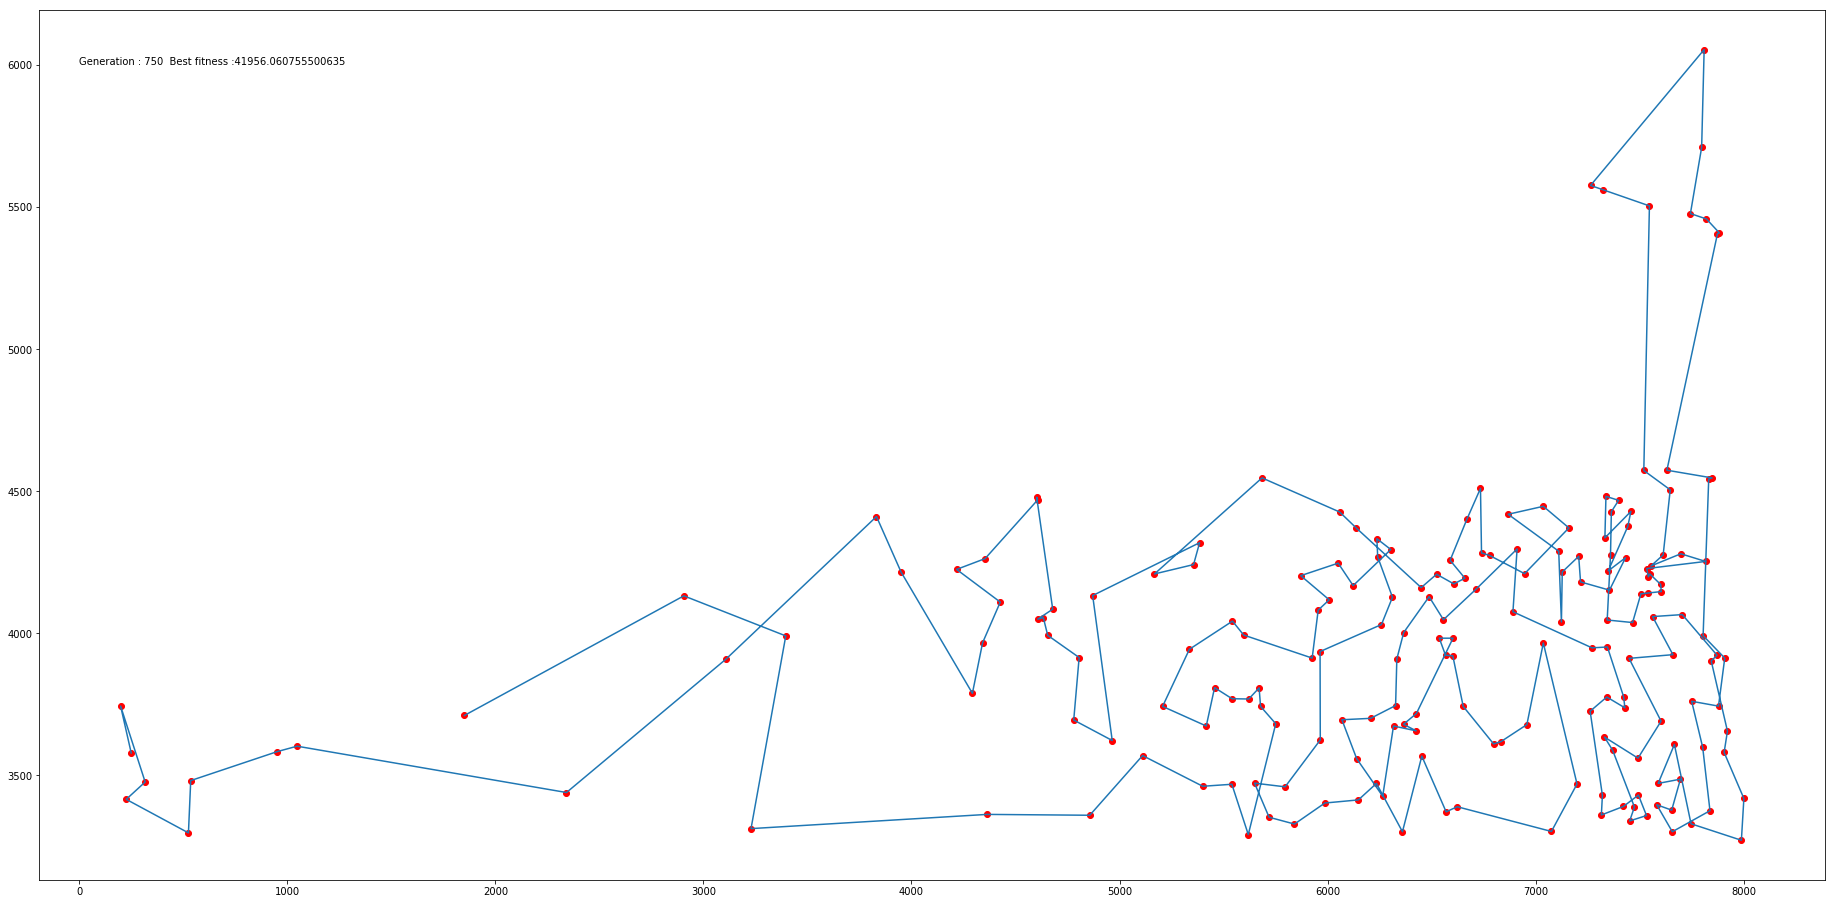

------800
Best individual is number 33 with a fitness of 41158.95917037541
Average fitness is 42888.89635378557


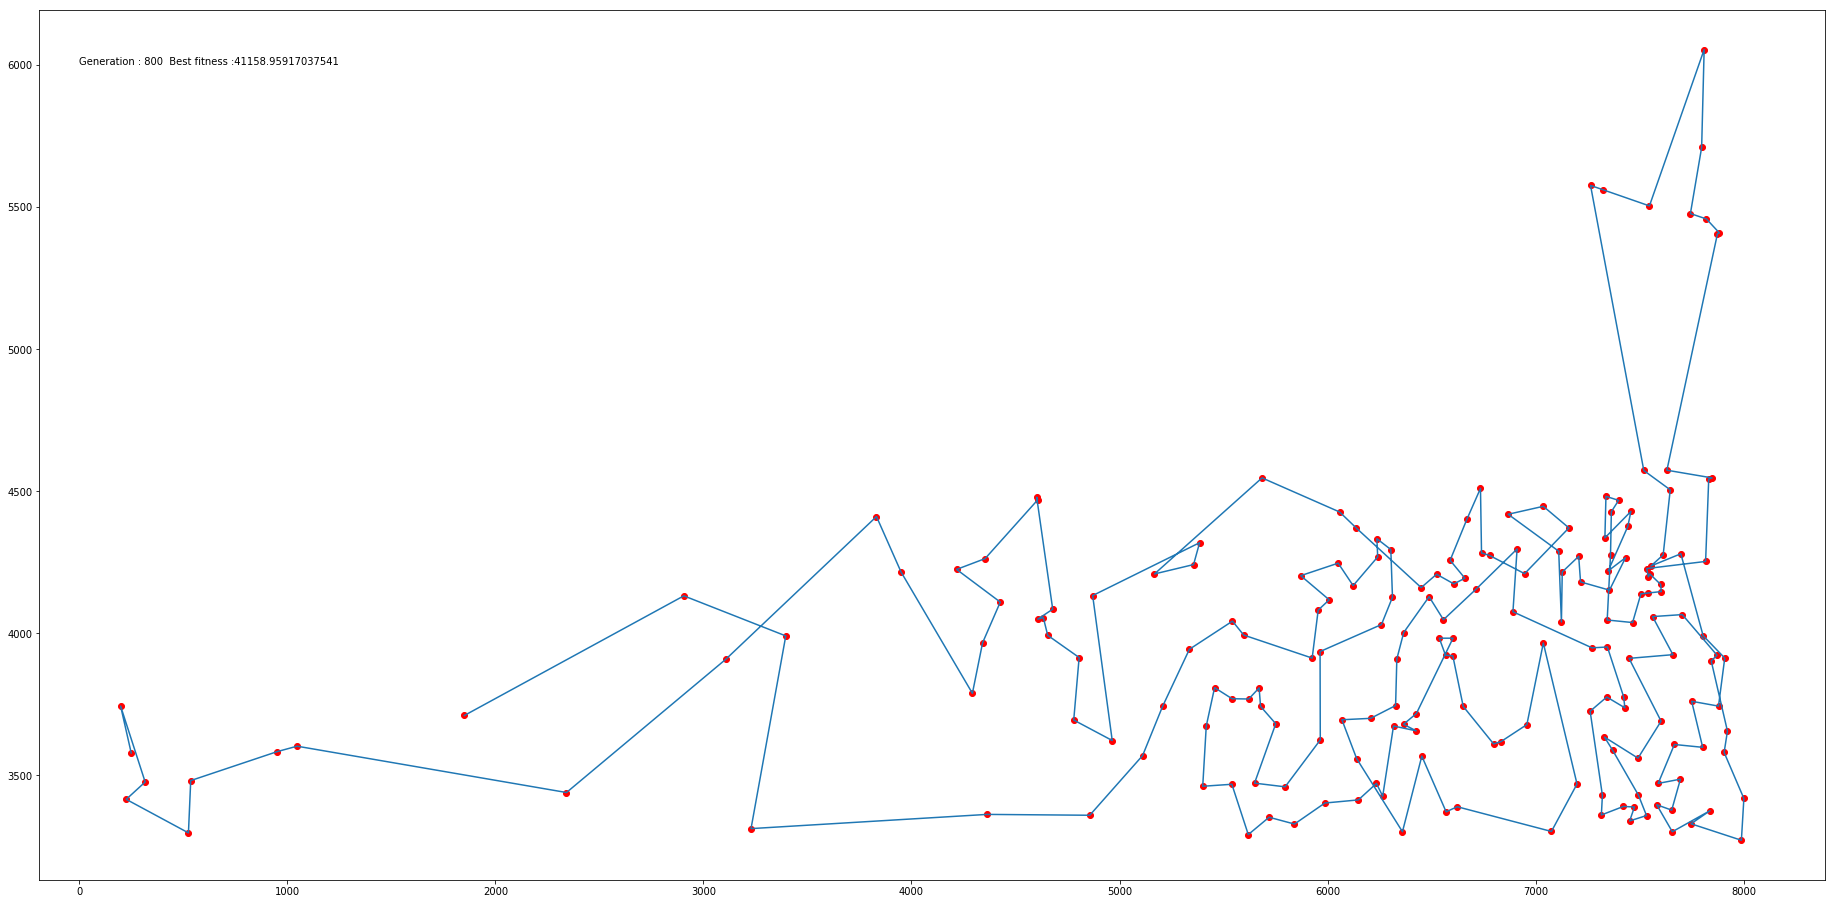

------850
Best individual is number 112 with a fitness of 40258.44792022454
Average fitness is 41862.86235034641


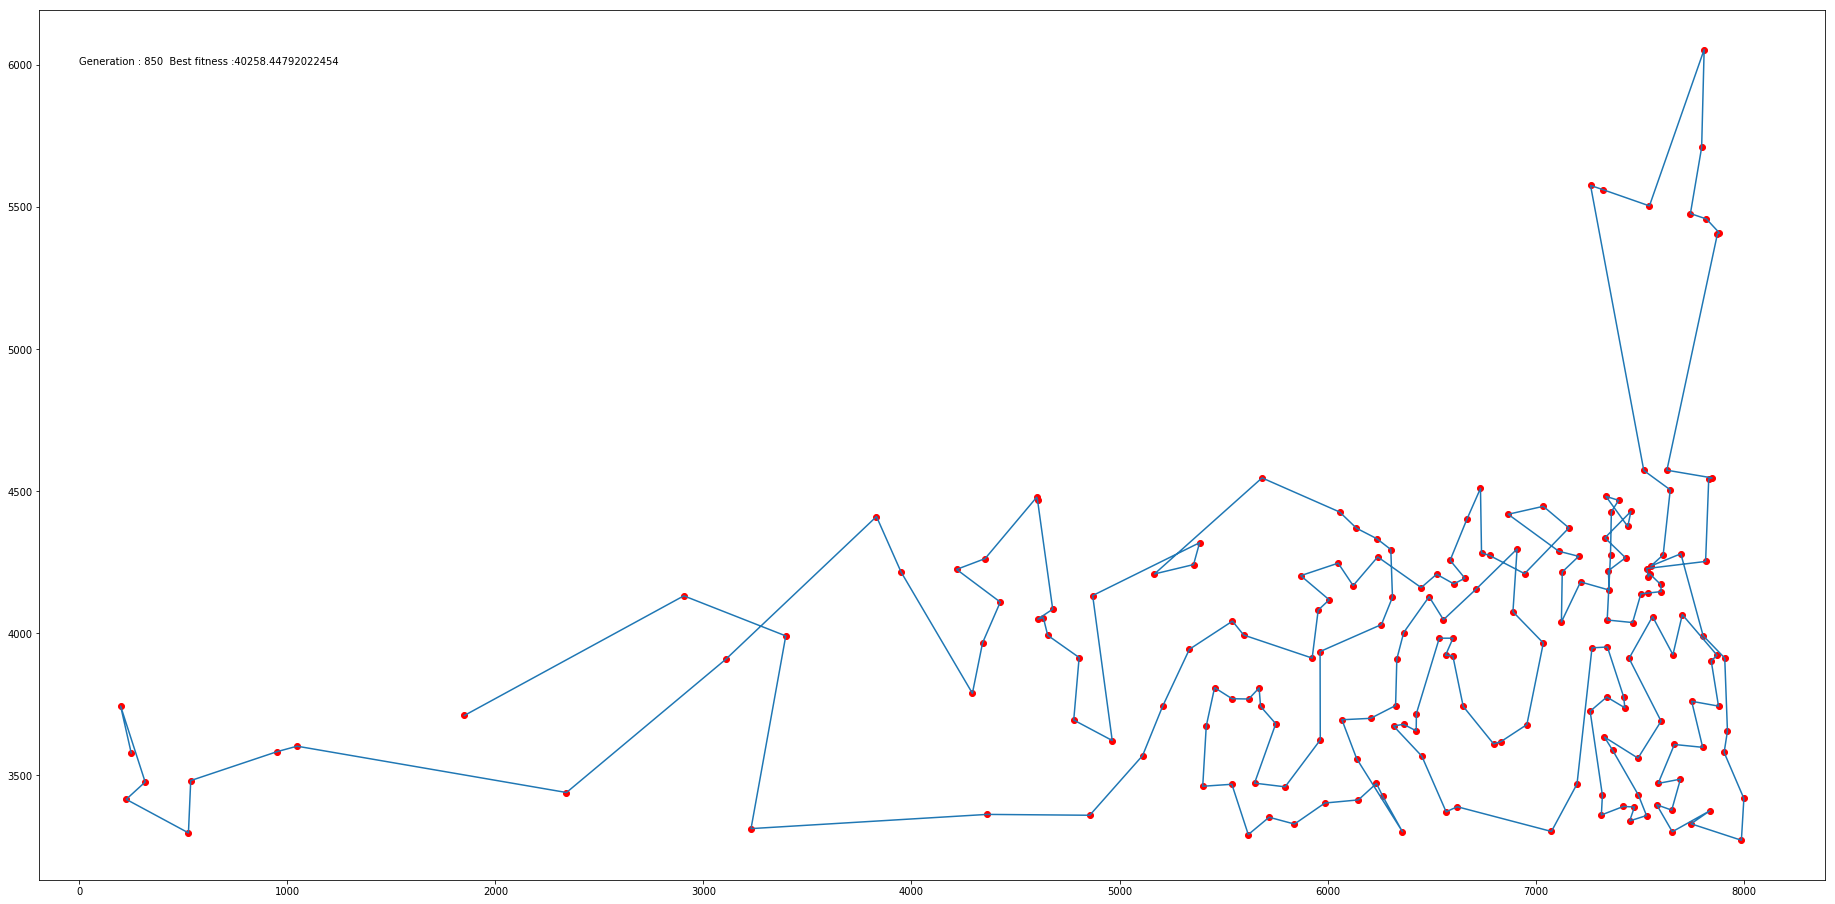

------900
Best individual is number 256 with a fitness of 38596.09657529676
Average fitness is 39976.44747019436


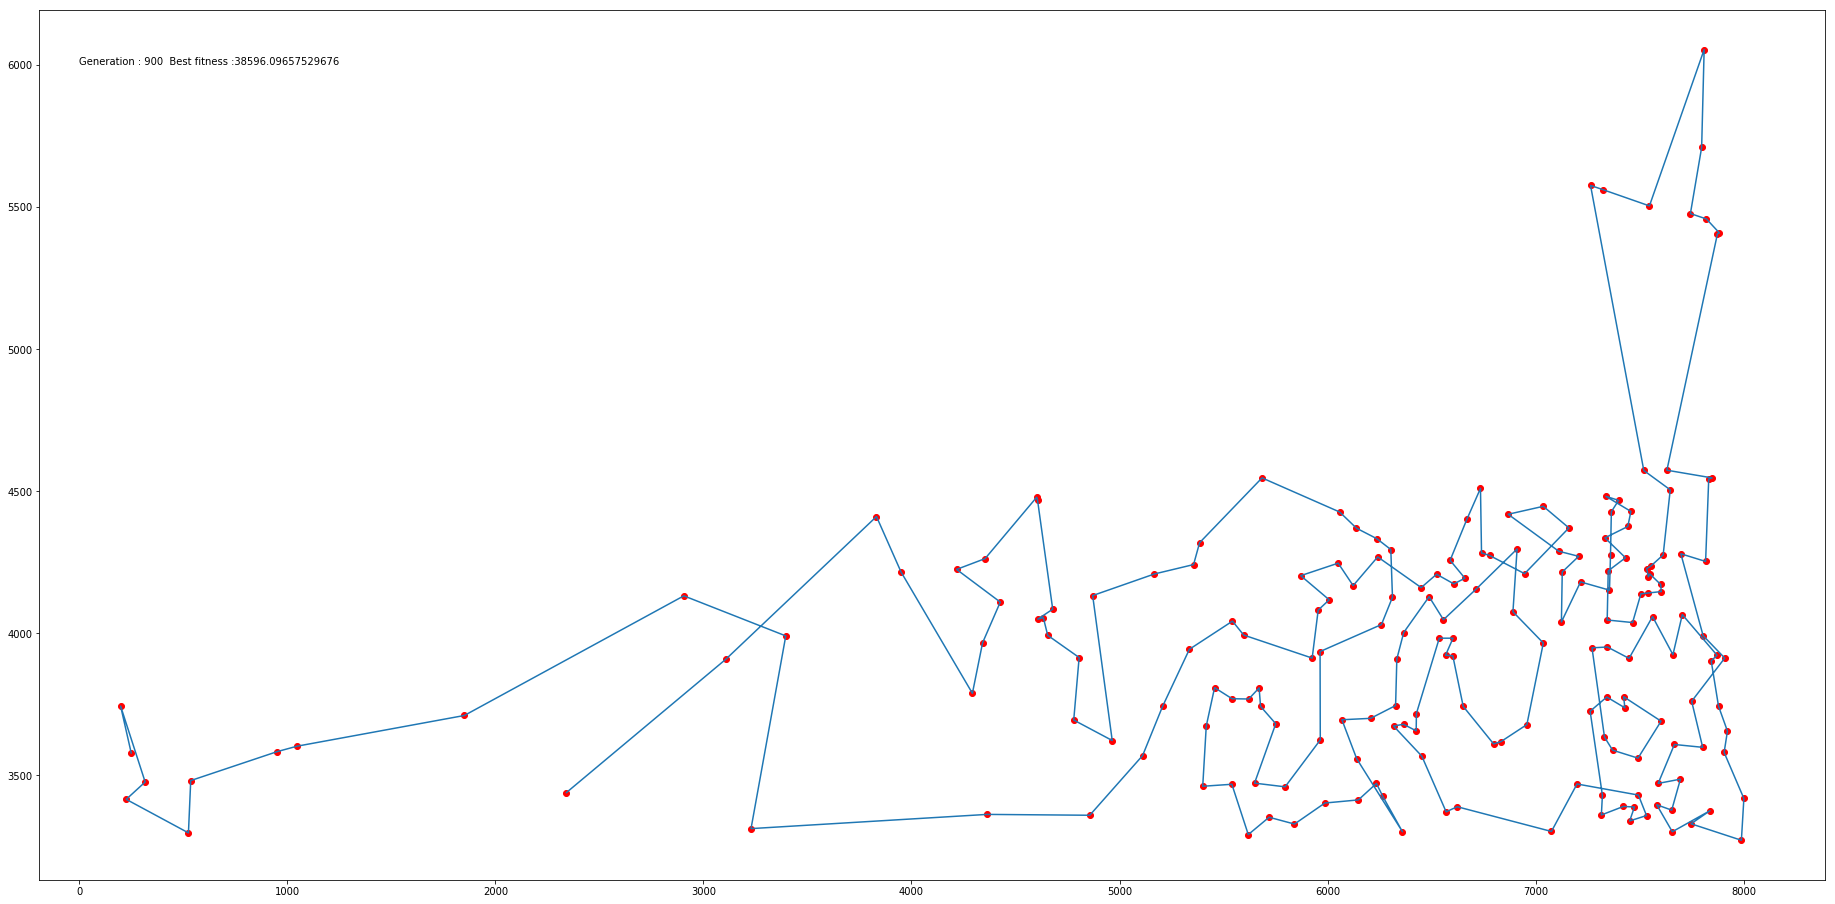

------950
Best individual is number 0 with a fitness of 38289.0340477808
Average fitness is 39498.92512255194


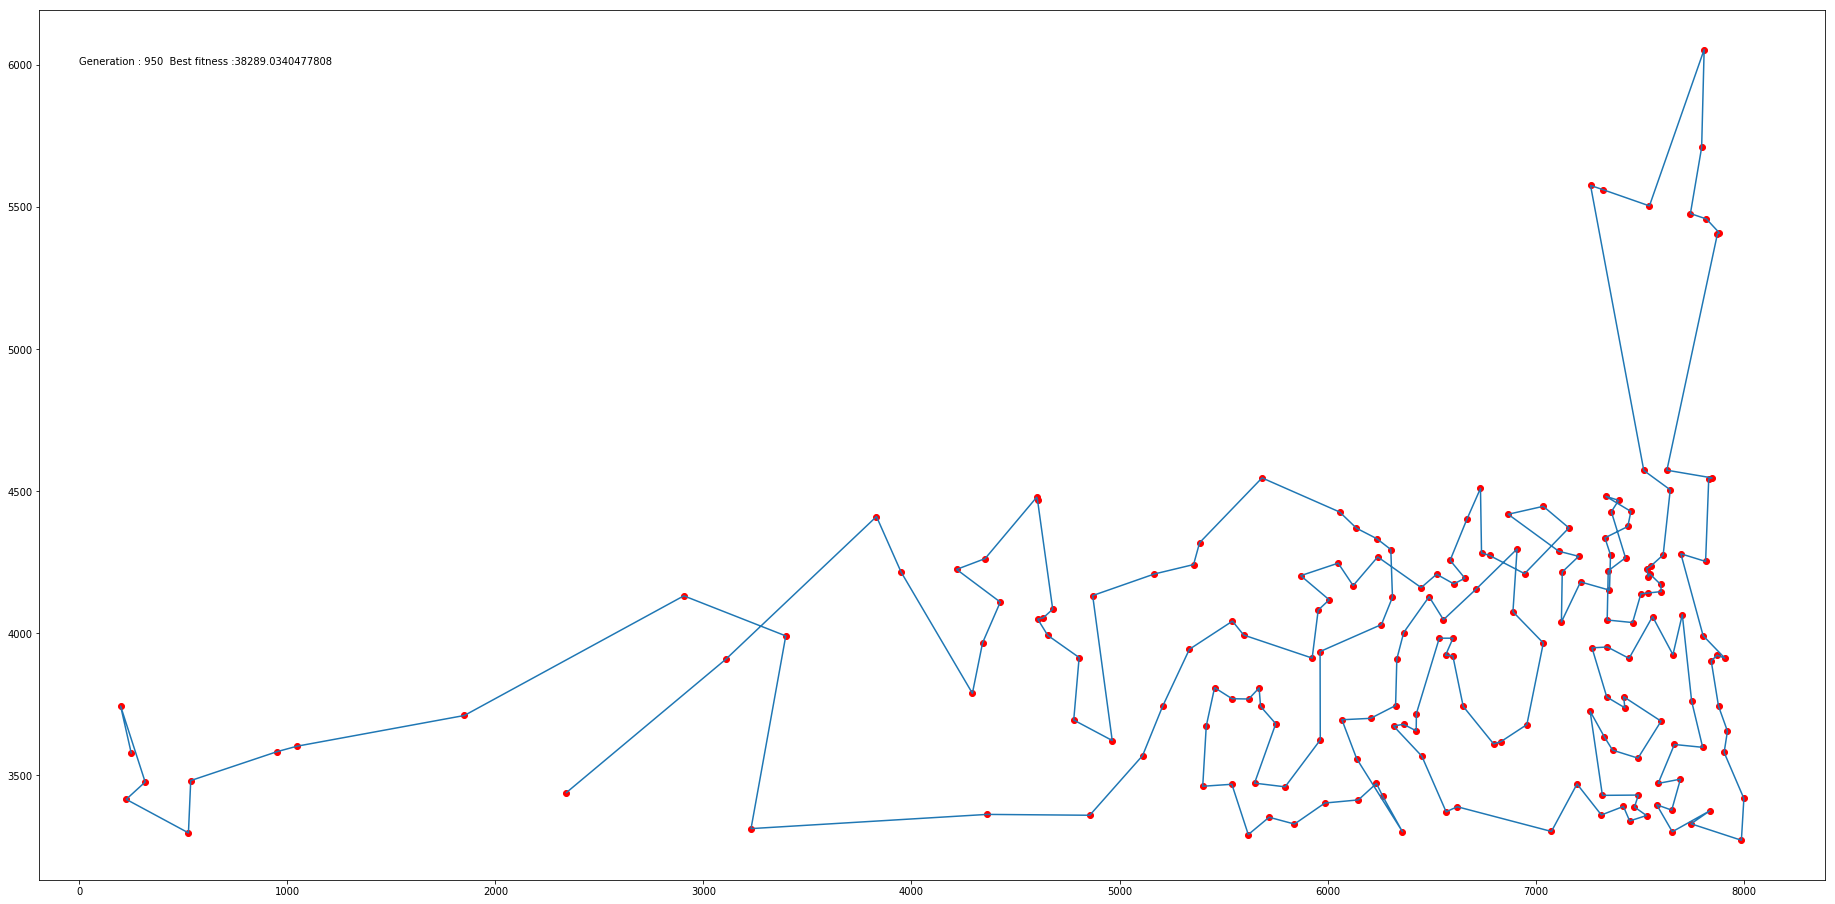

In [16]:
#initialize the list of boxplot values
bxplot=list()
bxplot[:]=[]

#max_iterations=max_iterations

#this is used to show a progressbar as our GA runs
f = FloatProgress(min=0, max=max_iterations) # instantiate the bar
display(f) # display the bar
f.value=0

#The main GA loop
for j in range(0,max_iterations):
    #initialize empty population
    tmp_population=np.zeros((nindividuals,ncities),dtype=int)
    
    bxpltseries=list()
    bxpltseries[:]=[]
 
    #Populate the temporary population
    for i in range(0,int(nindividuals/2)):
        tmpa = tournament_selection(population,tournamentsize)
        tmpa_fitness = calculate_fitness(tmpa)

        tmpb = tournament_selection(population,tournamentsize)
        tmpb_fitness = calculate_fitness(tmpb)
        
        #Crossover or Reproduction
        if cx_probability>random():
            tmpc,tmpd=crossover(tmpa,tmpb)
        else:
            tmpc,tmpd=tmpa[:],tmpb[:]
        
        #this is used to create a boxplot in the end of the runs
        bxpltseries.append(tmpa_fitness)
        bxpltseries.append(tmpb_fitness)

        #Mutation
        if mx_probability>random():
            tmp2=mutate(tmpc)
            tmp_population[i]=tmp2[:]
        
            tmp3=mutate(tmpd)
            tmp_population[int(nindividuals/2)+i]=tmp3[:]
        
        else:
            tmp_population[i]=tmpc[:]
            tmp_population[int(nindividuals/2)+i]=tmpd[:]
    
    
    #change here to make the plots more or less frequent
    # j%5 prints a plot every 5 generations, j%10 prints one every 10 generations
    if j%50==0:
        print('------' + str(j))
        bxplot.append(bxpltseries)
        draw_scatter_plot('Generation : ' + str(j))
    
    population=tmp_population[:]
    f.value += 1
    
f.close() #hide progressbar

### Visualize the resulting fitnesses

The traveling salesman problem is a minimization problem, meaning that we want to achive the minimal distance the salesman must travel to reach all cities.<br>
The Fitness evolution throughout the generations will show a curve that will lower the value quickly and then seems to stabilize the higher the generation count is.

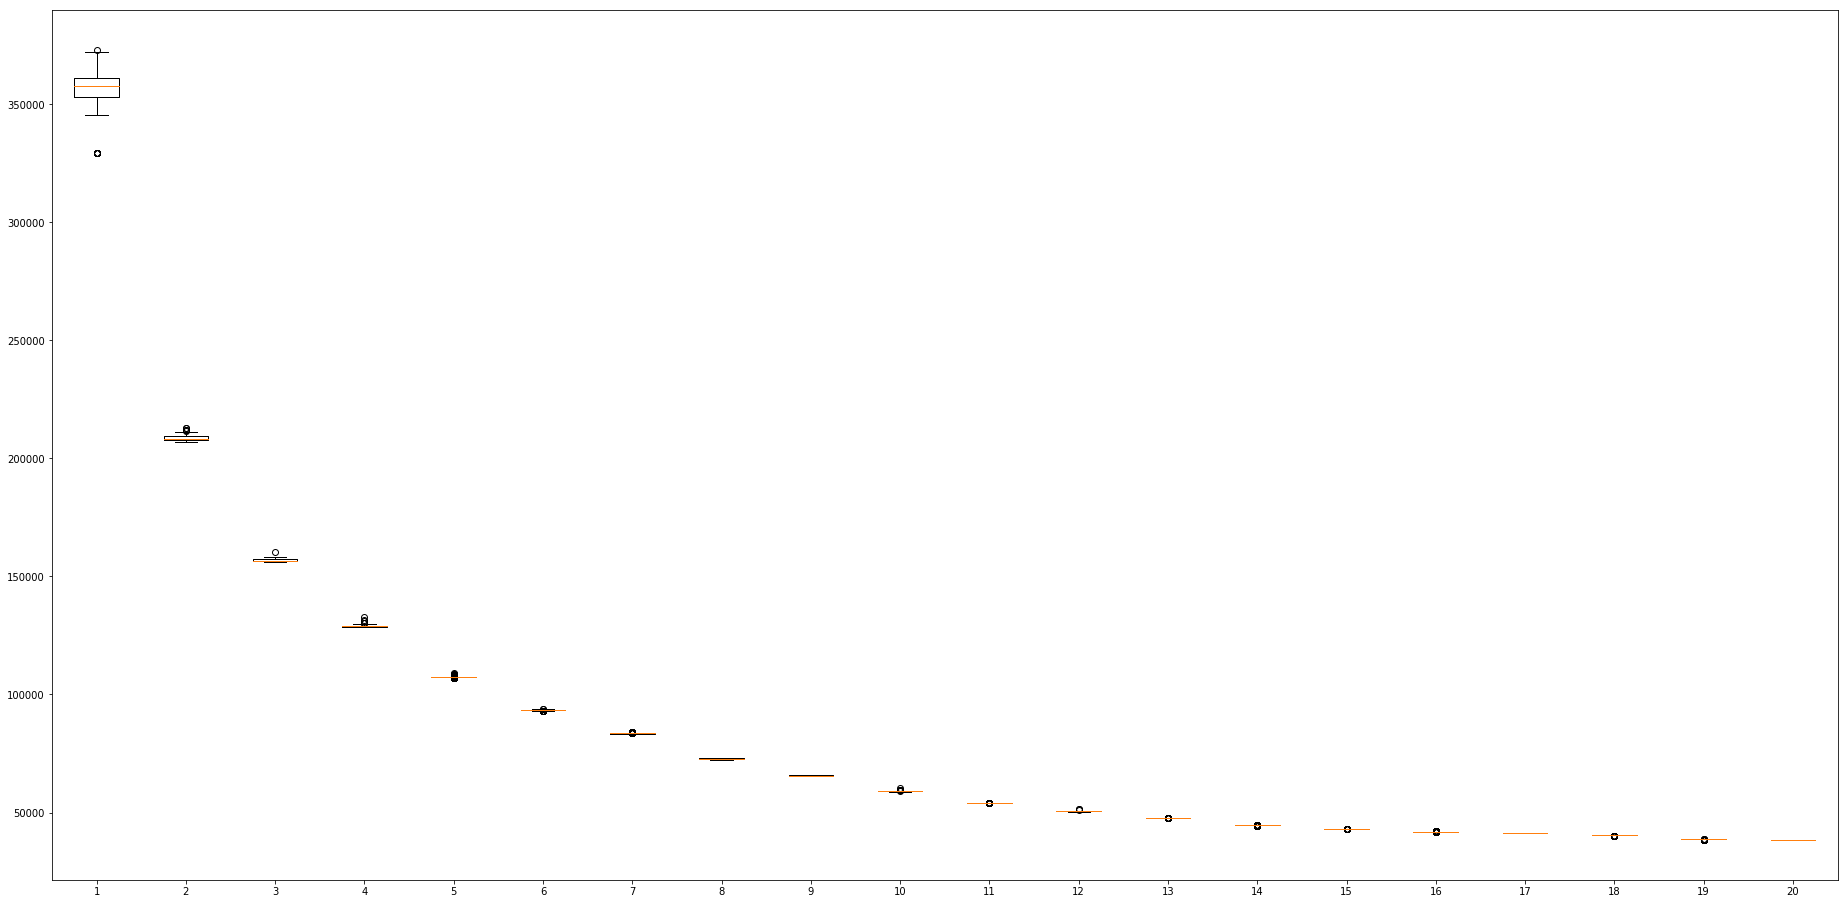

In [17]:
plt.pyplot.boxplot(bxplot)

plt.pyplot.show()

The figure above shows a typical hockeystick plot.

Remember this is an heuristic algorith, each time it is run the result will be different, maybe if you run it you'll get a better result :)

Hope this was usefull to you, please feel free to contact the author at jcanelhas@gmail.com